<a href="https://colab.research.google.com/github/Group-ProjectE17/PCA-Analysics/blob/main/Introduction_2_Data_Science_Muga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Function Definitions

## Functions New

### DB Setup/Edit Manipulation Funtions

In [58]:
def send_email(senderName,senderEmail,senderEmailPswd,recieverEmail,emailSubject,emailBody):
    # creates SMTP session
    s = smtplib.SMTP('smtp.gmail.com', 587)
    # start TLS for security
    s.starttls()
    # Authentication
    s.login(senderEmail,senderEmailPswd)     
    # message to be sent
    toEmails=', '.join(recieverEmail)
    #message = 'From: '+senderName+'<'+senderEmail+'>\n'+'To: <'+toEmails+'>\n'+'Subject: '+emailSubject+'\n\n'+emailBody;
    message = 'From: '+senderName+'<'+senderEmail+'>\n'+'To: <'+toEmails+'>\n'+'Subject: '+emailSubject+'\n\n'+emailBody;
    #academic.affairs@sltc.ac.lk
    # sending the mail
    #s.sendmail(senderEmail, recieverEmail, message)   
    # terminating the session
    s.quit()
    return print('e-mail sent to '+toEmails)

In [59]:
def create_table_with_update_history(dataPDF,tableName,engine):
    dataPDF.to_sql(tableName,engine,if_exists='replace',index=True,index_label='id')
    dataPDF[tableName+'_update_comment']='Entry created'
    dataPDF.to_sql(tableName+'_update_history',engine,if_exists='replace',index=True,index_label='id')
    return 'Tables {} and {} Created'.format(tableName,tableName+'_update_history')

In [60]:
def create_DB(historyTables,tablesWithoutHistory,SQLengine):
    tableNamesWithHistory=os.listdir(historyTables)
    print(tableNamesWithHistory)
    tableNamesWithoutHistory=os.listdir(tablesWithoutHistory)
    for flnm in tableNamesWithHistory:
        dataPDF=pd.read_csv(historyTables+flnm).fillna('')
        tableName=flnm.split('.')[0]
        create_table_with_update_history(dataPDF,tableName,SQLengine)
    for flnm in tableNamesWithoutHistory:
        dataPDF=pd.read_csv(tablesWithoutHistory+flnm).fillna('')
        tableName=flnm.split('.')[0]
        dataPDF.to_sql(tableName,SQLengine,if_exists='replace',index=True,index_label='id')
    return 'DB Created'

In [61]:
def create_DB_simple(directoryPath,SQLengine):
    tableNames=os.listdir(directoryPath)
    for flnm in tableNames:
        dataPDF=pd.read_csv(directoryPath+flnm).fillna('')
        tableName=flnm.split('.')[0]
        dataPDF.to_sql(tableName,SQLengine,if_exists='replace',index=True,index_label='id')
    return 'DB Created'

In [62]:
def update_table_with_logging(SQLengine,DB_query_obj,tableName0,filterColList0,updateDataPDF0,updateComment0):
    updateDataDict=updateDataPDF0.to_dict(orient='records')
    filterDict={}
    for dct in updateDataDict:
        updateCols=list(set([*updateDataPDF0]).difference(set(filterColList0)))
        updateVals=[dct[xx] for xx in updateCols]
        filterDict={fcs:dct[fcs] for fcs in filterColList0}
        DB_query_obj.update_records(SQLengine,tableName0,filterDict,updateCols,updateVals)
        whereStr=' AND '.join([ky+'="'+str(filterDict[ky])+'"' for ky in [*filterDict]])
        updatedEntryDict=pd.read_sql('SELECT * FROM {} WHERE {}'.format(tableName0,whereStr),engine).fillna('').drop(columns=['id']).to_dict(orient='records')[0]
        updateHistoryCols=[*updatedEntryDict]
        updateHistoryVals=[updatedEntryDict[xx] for xx in updateHistoryCols]
        updateHistoryCols+=[tableName0+'_update_comment']
        updateHistoryVals+=[updateComment0]
        msg2=DB_query_obj.insert_record(SQLengine,tableName0+'_update_history',updateHistoryCols,updateHistoryVals)
    return msg2

In [63]:
def update_table(SQLengine,DB_query_obj,tableName0,filterColList0,updateDataPDF0,updateComment0):
    updateDataDict=updateDataPDF0.to_dict(orient='records')
    filterDict={}
    for dct in updateDataDict:
        updateCols=list(set([*updateDataPDF0]).difference(set(filterColList0)))
        updateVals=[dct[xx] for xx in updateCols]
        filterDict={fcs:dct[fcs] for fcs in filterColList0}
        msg=DB_query_obj.update_record(SQLengine,tableName0,filterDict,updateCols,updateVals)
    return msg

### DB Query Functions

In [64]:
class mugas_DB_functions:
  
    def __init__(self): 
        self=[];

    def sql_request(self,SQLengine,params):
        return pd.read_sql(params['sqlQuery'], SQLengine).to_dict(orient='records')

    def get_all_tables(self,sqlEngine):
        return pd.read_sql_query('SHOW TABLES', sqlEngine).to_dict(orient='records')


    def get_filtered_columns(self,SQLengine,params):
        db_table_name=params['db_table_name']
        filterDict=params['filterDict']
        filterPairs=[ky+'="{}"'.format(filterDict[ky]) for ky in [*filterDict]]
        sql_q="SELECT {} FROM {} WHERE {}"
        return pd.read_sql(sql_q.format(','.join(params['returnColumns']),db_table_name,' AND '.join(filterPairs)),SQLengine).to_dict(orient='records')

    def get_all_records_between_ranges(self,SQLengine,params):
        db_table_name=params['db_table_name']
        colName=params['colName']
        startVal=params['startVal']
        endVal=params['endVal']
        sql_q="SELECT {} FROM {} WHERE {} BETWEEN {} AND {}"
        return pd.read_sql(sql_q.format(','.join(params['returnColumns']),db_table_name,colName,startVal,endVal),SQLengine).to_dict(orient='records')

    def get_filtered_records_between_ranges(self,SQLengine,params):
        db_table_name=params['db_table_name']
        filterDict=params['filterDict']
        filterPairs=[ky+'="{}"'.format(filterDict[ky]) for ky in [*filterDict]]
        colName=params['colName']
        startVal=params['startVal']
        endVal=params['endVal']
        sql_q="SELECT {} FROM {} WHERE {} BETWEEN {} AND {} AND {}"
        return pd.read_sql(sql_q.format(','.join(params['returnColumns']),db_table_name,colName,startVal,endVal,' AND '.join(filterPairs)),SQLengine).to_dict(orient='records')


    def get_all_records_column_values_in(self,SQLengine,params):
        db_table_name=params['db_table_name']
        colName=params['colName']
        colVals=params['colVals']
        sql_q="SELECT {} FROM {} WHERE {} IN ({})"
        return pd.read_sql(sql_q.format(','.join(params['returnColumns']),db_table_name,colName,', '.join([str(xx) for xx in colVals])),SQLengine).to_dict(orient='records')

    def get_filtered_records_column_values_in(self,SQLengine,params):
        db_table_name=params['db_table_name']
        colName=params['colName']
        colVals=params['colVals']
        filterDict=params['filterDict']
        filterPairs=[ky+'="{}"'.format(filterDict[ky]) for ky in [*filterDict]]
        sql_q="SELECT {} FROM {} WHERE {} IN ({}) AND {}"
        return pd.read_sql(sql_q.format(','.join(params['returnColumns']),db_table_name,colName,', '.join([str(xx) for xx in colVals]),' AND '.join(filterPairs)),SQLengine).to_dict(orient='records')

    def delete_record(self,SQLengine,params):
        filterStrLst=[fltcol+'="{}"'.format(params['filterDict'][fltcol]) for fltcol in [*params['filterDict']]]
        filterStr=' AND '.join(filterStrLst)
        sqlQuery="DELETE FROM {} WHERE {}".format(params['db_table_name'],filterStr)
        sql.execute(sqlQuery, SQLengine)
        return 'Table {} updated successfully'.format(params['db_table_name'])

    def update_record(self,SQLengine,params):
        db_table_name=params['db_table_name']
        filterDict=params['filterDict']
        updateDict=params['updateDict']
        filterStrLst=[fltcol+'="{}"'.format(params['filterDict'][fltcol]) for fltcol in [*params['filterDict']]]
        filterStr=' AND '.join(filterStrLst)
        updatePairs=['{}="{}"'.format(ky,updateDict[ky]) for ky in [*updateDict]]
        sqlQuery='UPDATE {} SET {} WHERE {}'.format(db_table_name,', '.join(updatePairs),filterStr)
        sql.execute(sqlQuery, SQLengine)
        return 'Table {} updated successfully'.format(db_table_name)

    def insert_record(self, sqlEngine,params):
        db_table_name=params['db_table_name']
        updateDict=params['updateDict']
        db_table_PDF=pd.read_sql('SELECT * FROM {} WHERE id=(SELECT max(id) FROM {})'.format(db_table_name,db_table_name), sqlEngine)
        diffCols=set([*updateDict]).difference(set([*db_table_PDF]))
        if len(diffCols) == 0:
            lastIndex=db_table_PDF['id'].values[0]
            insert_entry_PDF=pd.DataFrame(columns=[*db_table_PDF],index=[int(lastIndex+1)]).drop(columns=['id'])
            insert_entry_PDF.loc[int(lastIndex+1),[*updateDict]]=[updateDict[ky] for ky in [*updateDict]]
            insert_entry_PDF.to_sql(db_table_name,sqlEngine,if_exists='append',index=True,index_label='id')
            msg='Table {} updated successfully'.format(db_table_name)
        else:
            msg='Insert columns'+', '.join(diffCols)+' not in table'
        return msg



    def bulk_update_table_entries(self,SQLengine,params):
        filterCols=params['filterCols']
        updateDataDictList=params['updateDictList']
        filterDict={}
        for dct in updateDataDictList:
            filterDict={ky:dct[ky] for ky in filterCols}
            msg=self.update_record(SQLengine,{'db_table_name':params['db_table_name'],'filterDict':filterDict,'updateDict':dct})
        return msg

    def bulk_delete_table_entries(self,SQLengine,params):
        deleteDataDictList=params['updateDictList']
        filterDict={}
        for dct in deleteDataDictList:
            msg=self.delete_record(SQLengine,{'db_table_name':params['db_table_name'],'filterDict':dct})
        return msg

    def bulk_insert_table_entries(self,SQLengine,params):
        updateDataDictList=params['updateDictList']
        for dct in updateDataDictList:
            msg=self.insert_record(SQLengine,{'db_table_name':params['db_table_name'],'updateDict':dct})
        return msg

    def bulk_update_table_entries_with_logging(self,SQLengine,params):
        filterCols=params['filterCols']
        updateDataDictList=params['updateDictList']
        filterDict={}
        for dct in updateDataDictList:
            filterDict={ky:dct[ky] for ky in filterCols}
            msg=self.update_record(SQLengine,{'db_table_name':params['db_table_name'],'filterDict':filterDict,'updateDict':dct})
            dct[params['db_table_name']+'_updated_by']=params['updatedBy']
            dct[params['db_table_name']+'_update_comment']=params['updateComment']
            dct[params['db_table_name']+'_updated_on']=datetime.now().strftime('%Y/%m/%d %H:%M:%S')
            msg=self.insert_record(SQLengine,{'db_table_name':params['db_table_name']+'_update_history','updateDict':dct})
        return msg

    def bulk_delete_table_entries_with_logging(self,SQLengine,params):
        deleteDataDictList=params['updateDictList']
        filterDict={}
        for dct in deleteDataDictList:
            msg=self.delete_record(SQLengine,{'db_table_name':params['db_table_name'],'filterDict':dct})
            dct[params['db_table_name']+'_updated_by']=params['updatedBy']
            dct[params['db_table_name']+'_update_comment']=params['updateComment']
            dct[params['db_table_name']+'_updated_on']=datetime.now().strftime('%Y/%m/%d %H:%M:%S')
            msg=self.insert_record(SQLengine,{'db_table_name':params['db_table_name']+'_update_history','updateDict':dct})
        return msg

    def bulk_insert_table_entries_with_logging(self,SQLengine,params):
        updateDataDictList=params['updateDictList']
        for dct in updateDataDictList:
            msg=self.insert_record(SQLengine,{'db_table_name':params['db_table_name'],'updateDict':dct})
            dct[params['db_table_name']+'_updated_by']=params['updatedBy']
            dct[params['db_table_name']+'_update_comment']=params['updateComment']
            dct[params['db_table_name']+'_updated_on']=datetime.now().strftime('%Y/%m/%d %H:%M:%S')
            msg=self.insert_record(SQLengine,{'db_table_name':params['db_table_name']+'_update_history','updateDict':dct})
        return msg

    def create_table_4m_csv_with_update_history(self, SQLengine, params):
        dataPDF=pd.read_csv(params['filePath'])
        tableName=params['db_table_name']
        dataPDF.to_sql(tableName,engine,if_exists='replace',index=True,index_label='id')
        dataPDF[tableName+'_update_comment']='Entry created'
        dataPDF.to_sql(tableName+'_update_history',SQLengine,if_exists='replace',index=True,index_label=tableName+'_update_history_id')
        return 'Tables {} and {} Created'.format(tableName,tableName+'_update_history')
    
    def create_table_4m_csv(self, SQLengine, params):
        dataPDF=pd.read_csv(params['filePath'])
        tableName=params['db_table_name']
        dataPDF.to_sql(tableName,engine,if_exists='replace',index=True,index_label=tableName+'_id')
        return 'Tables {} Created'.format(tableName)

    def create_DB_from_csv_directory(self, SQLengine,params):
        historyTablesPath=params['withHistoryTablesPath']
        tablesWithoutHistoryPath=params['withoutHistoryTablesPath']
        tableNamesWithHistory=os.listdir(historyTablesPath)
        tableNamesWithoutHistory=os.listdir(tablesWithoutHistoryPath)
        for flnm in tableNamesWithHistory:
            tableName=flnm.split('.')[0]
            self.create_table_4m_csv_with_update_history(SQLengine, {'db_table_name':tableName,'filePath':historyTablesPath+flnm})
        for flnm in tableNamesWithoutHistory:
            dataPDF=pd.read_csv(tablesWithoutHistoryPath+flnm)
            tableName=flnm.split('.')[0]
            dataPDF.to_sql(tableName,SQLengine,if_exists='replace',index=True,index_label=tableName+'_id')
        return 'DB Created'

    def get_all_tables(self,sqlEngine):
        return pd.read_sql_query('SHOW TABLES', sqlEngine)


In [65]:
def DataBaseAccessApp_fn(func): 
     
    def inner1(a,b): 
        c=func(a,b) 
        return c
            
    return inner1 
    
def DataBaseAccessApp(sqlEngine,inputDict):
    function_to_be_called = DataBaseAccessApp_fn(inputDict['functionName'])  
    return function_to_be_called(sqlEngine,inputDict['functionParameters']) 
     

In [66]:
def update_record(SQLengine,params):
    db_table_name=params['db_table_name']
    filterDict=params['filterDict']
    updateDict=params['updateDict']
    filterStrLst=[fltcol+'="{}"'.format(params['filterDict'][fltcol]) for fltcol in [*params['filterDict']]]
    filterStr=' AND '.join(filterStrLst)
    numericFieldsInfoDict=updateDict['numericFieldsInfoDict']
    textFieldsInfoDict=updateDict['textFieldsInfoDict']

    if len(textFieldsInfoDict)!=0:
        sqlqText="UPDATE {} SET ".format(db_table_name)+ ', '.join([xx+"='{}'".format(textFieldsInfoDict[xx]) for xx in [*textFieldsInfoDict]])+" WHERE {}".format(filterStr)
        sqlqText=sqlqText.replace('\\','\\\\')
        SQLengine.execute(sqlqText) #
    if len(numericFieldsInfoDict)!=0:
        sqlqNumeric="UPDATE {} SET ".format(db_table_name)+ ', '.join([xx+"={}".format(numericFieldsInfoDict[xx]) for xx in [*numericFieldsInfoDict]])+" WHERE {}".format(filterStr)
        SQLengine.execute(sqlqNumeric)

    return 'Table {} updated successfully'.format(db_table_name)

def insert_record(sqlEngine,params):
    db_table_name=params['db_table_name']
    updateDict=params['updateDict']
    db_table_PDF=pd.read_sql('SELECT * FROM {} WHERE id=(SELECT max(id) FROM {})'.format(db_table_name,db_table_name), sqlEngine)
    diffCols=set([*updateDict]).difference(set([*db_table_PDF]))
    if len(diffCols) == 0:
        lastIndex=db_table_PDF['id'].values[0]
        insert_entry_PDF=pd.DataFrame(columns=[*db_table_PDF],index=[int(lastIndex+1)]).drop(columns=['id'])
        insert_entry_PDF.loc[int(lastIndex+1),[*updateDict]]=[updateDict[ky] for ky in [*updateDict]]
        insert_entry_PDF.to_sql(db_table_name,sqlEngine,if_exists='append',index=True,index_label='id')
        msg='Table {} updated successfully'.format(db_table_name)
    else:
        msg='Insert columns'+', '.join(diffCols)+' not in table'
    return msg

### Plot Functions

In [67]:
def grouped_itemized_graphs(dataPDF, gpFieldName, gpFldList, plotFieldName, plotFldList, xLabel, yLabel, figTitle, barMode):
  xx1=[]; yy1=[]; cc1=[]; traceNames1=[];
  aaPDF=pd.DataFrame(yy1) #,index=plotFldList, columns=gpFldList)
  
  for xx in gpFldList:
    if gpFieldName==None:
      temp=dataPDF
    else:
      temp=dataPDF[dataPDF[gpFieldName]==xx];    
    xxx1=[]; yyy1=[]; ccc1=[];
    
    for tstdt in plotFldList:
      xxx1+=[tstdt]
      yyy1+=[len(temp[temp[plotFieldName]==tstdt])]
    xx1+=[xxx1];
    yy1+=[yyy1];
    traceNames1+=[xx]
    
  fig = go.Figure()
  for i,x in enumerate(xx1):
    fig.add_trace(go.Bar(y=yy1[i], x=x, name=traceNames1[i]))
  
  
  fig.update_layout(title=figTitle, xaxis_title=xLabel, yaxis_title=yLabel, barmode=barMode)
  #fig.show()

  tmpx0=pd.DataFrame(yy1)
  tmpx00=tmpx0.transpose() #,index=plotFldList, columns=gpFldList)
  aaPDF=pd.DataFrame(tmpx00.to_numpy(),index=plotFldList, columns=gpFldList)
  return fig, aaPDF

In [68]:
def time_duration(labelName,dataPDF,startDateColumn,endDateColumn):
  tempPDF=dataPDF.copy(deep=True) # pd.DataFrame(index=dataPDF.index.values)
  #dt=pd.to_datetime(dataPDF[endDateColumn].to_list(), dayfirst=True, errors='coerce').to_pydatetime()-pd.to_datetime(dataPDF[startDateColumn].to_list(), dayfirst=True, errors='coerce').to_pydatetime()
  dt=pd.to_datetime(dataPDF[endDateColumn].to_list(), dayfirst=True, errors='coerce')-pd.to_datetime(dataPDF[startDateColumn].to_list(), dayfirst=True, errors='coerce')
  tempPDF[labelName]=dt/np.timedelta64(1, "D") 
  tempPDF[labelName]=tempPDF[labelName].fillna(0.0)
  tempPDF.loc[tempPDF[labelName]<0,labelName]=0.0
  return tempPDF

In [69]:
def bubble_scatter(x, y, z, color, displayText, traceName, figTitle, xLabel, yLabel):
    fig = go.Figure()

    #for records in allWorkSheetRecords[2]:
    fig.add_trace(go.Scatter(
        x=x, y=y,
        name=traceName, text=displayText,
        marker_size=abs(np.array(z)),
        ))

    # Tune marker appearance and layout
    fig.update_traces(mode='markers', marker=dict(sizemode='area', color=color,
                                                  sizeref=2.*max(z)/(40.**2),sizemin=4, line_width=2))

    fig.update_layout(
        title=figTitle,
        xaxis=dict(
            title=xLabel,
            gridcolor='white',
            #type='log',
            gridwidth=2,
        ),
        yaxis=dict(
            title=yLabel,
            gridcolor='white',
            gridwidth=2,
        ),
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
    )
    #fig.show()
    return fig

In [70]:
def symptom_duration(dataPDF,symptom,labelName):
    startEventStartDate='symptom_'+symptom+'_start_date'
    endEventEndDate='symptom_'+symptom+'_end_date'
    processedDataPDF=time_duration(labelName,dataPDF,startEventStartDate,endEventEndDate)
    return processedDataPDF

## Data Analysis

In [71]:
import sklearn
from sklearn.mixture import GaussianMixture

In [72]:
class mugas_data_analysis:
    def principle_component_values(self, modelDF, predictDF, nnPCs):
        tempModelDataPDF=modelDF.copy();
        tempPredictDataPDF=predictDF.copy();
        #nnPCs=min(len(tempModelDataPDF.index.values),len(tempModelDataPDF.columns));
        #nnPCs='mle'
        pca=sklearn.decomposition.PCA(n_components=nnPCs);
        modelnumPCA=pca.fit_transform(tempModelDataPDF);
        PCweights=pca.singular_values_;
        PCAmodelScore=pca.score(tempModelDataPDF);
        predictnumPCA=pca.transform(tempPredictDataPDF);
        PCApredictScore=pca.score(tempPredictDataPDF);
        #scaling=sklearn.preprocessing.StandardScaler().fit(pd.DataFrame(numPCA));
        #scaledPCA=scaling.transform(numPCA);
        transformer = sklearn.decomposition.FactorAnalysis(n_components=nnPCs); # n_components=nnPCs, random_state=0);
        modelsvdFactor = transformer.fit_transform(tempModelDataPDF);
        svdFactormodelScore=transformer.score(tempModelDataPDF);
        predictsvdFactor = transformer.transform(tempPredictDataPDF);
        svdFactorpredictScore=transformer.score(tempPredictDataPDF);
    

        traceNames=[];
        for nn in range(len(PCweights)):
            traceNames+=['P'+str(nn)];

        mindex=tempModelDataPDF.index.values;
        pindex=tempPredictDataPDF.index.values;
        #figFactor=self.hist_plot(PPFactor.T,histBinSize, binRange, traceNames,'Distributions of the PC Factors','PC Factors','Frequency')
        pcaOutput={'traceNames':traceNames, 'fitScores': {'PCApredictScore':PCApredictScore, 'PCAmodelScore':PCAmodelScore, 'svdFactormodelScore':svdFactormodelScore, 'svdFactorpredictScore':svdFactorpredictScore}, 'PCweights':PCweights, 'modelnumPCA':pd.DataFrame(modelnumPCA,index=mindex),'predictnumPCA':pd.DataFrame(predictnumPCA,index=pindex), 'modelsvdFactor':pd.DataFrame(modelsvdFactor,index=mindex),  'predictsvdFactor':pd.DataFrame(predictsvdFactor,index=pindex)}
        return pcaOutput

    def gmm_data_model(self, mData, nClusters):
        #mData - numeric centered np array of shape (ndata,nfactors)

        gmm = sklearn.mixture.GaussianMixture(n_components = nClusters)
        gmm.fit(mData)
        labels = gmm.predict(mData)
        clusterIC=[gmm.aic(mData), gmm.bic(mData)]
        print(clusterIC)
        fig1=md.scatter_plot3D(mData[:,0],mData[:,1],mData[:,2],labels)

        return {'gmm':gmm, 'clusterIC':clusterIC}


    def gmm_data_classifier(self, model_DataPDF, predict_DataPDF,nClusters):
        modelDataPDF0=model_DataPDF.copy();
        predictDataPDF0=predict_DataPDF.copy();
        modelData=modelDataPDF0.to_numpy();
        predictData=predictDataPDF0.to_numpy();
        nPCs=modelData.shape[1]
        #print([modelPCA[n].shape,predictPCA[n].shape])
        fitGMM=self.gmm_data_model(modelData,nClusters)
        gmm=fitGMM['gmm'];

        #Plabels=[];
        #for nn in range(nPCs):
        #    Plabels+=['PF'+str(nn)]

        mLabels = gmm.predict(modelData)
        #modelFitScore=gmm.score(modelData);
        modelDist={'Model Mean':gmm.means_, 'Model Covaraince':gmm.covariances_};
        modelSampleFitScore=gmm.score_samples(modelData);
        modelDataPDF0['labels']=mLabels
        modelDataPDF0['Fit Score']=modelSampleFitScore;

        pLabels = gmm.predict(predictData)
        #predictFitScore=gmm.score(predictData);
        predictProbDist=gmm.predict_proba(predictData);
        predictSampleFitScore=gmm.score_samples(predictData);

        predictDataPDF0['labels']=pLabels
        predictDataPDF0['Fit Score']=predictSampleFitScore;
        xx1=[]; yy1=[]; traceNames1=[];
        xx2=[]; yy2=[]; traceNames2=[];

        for kk in set(modelDataPDF0['labels'].to_list()):
            xx1+=[['All Data']];
            yy1+=[[len(modelDataPDF0[modelDataPDF0['labels']==kk])]];
            yy2+=[[len(predictDataPDF0[predictDataPDF0['labels']==kk])]];
            traceNames1+=['GP'+str(kk)]
        fig21=self.bar_plot(xx1,yy1,traceNames1,'Model Clusters','','Numbers','stack')
        fig31=self.bar_plot(xx1,yy2,traceNames1,'Predicted Clusters','','Numbers','stack')
        #print({'modelFitScore':modelFitScore, 'predictFitScore':predictFitScore})
        return {'labeled model data':modelDataPDF0, 'labeled predict data':predictDataPDF0,'fitScore':{'modelFitScore':modelSampleFitScore, 'predictFitScore':predictSampleFitScore},'Probability Model':modelDist}

    def logistic_reg_data_classifier(self, model_XDataPDF, model_YDataPDF, predict_XDataPDF):
        MXDataPDF=model_XDataPDF.copy();
        MYDataPDF=model_YDataPDF.copy();
        PXDataPDF=predict_XDataPDF.copy();
        clf = sklearn.linear_model.LogisticRegression(random_state=0).fit(MXDataPDF.to_numpy(), MYDataPDF.to_numpy());
        mLabels = clf.predict(MXDataPDF.to_numpy())
        modelDist=clf.predict_proba(MXDataPDF.to_numpy());
        modelSampleFitScore=clf.score(MXDataPDF.to_numpy(), MYDataPDF.to_numpy());
        MXDataPDF['labels']=mLabels
        mLabelTypes=list(set(mLabels));
        probLabels=[];
        for mlt in mLabelTypes:
            probLabels+=['p('+str(mlt)+')']
    
        MXDataPDF[probLabels]=modelDist;

        pLabels = clf.predict(PXDataPDF.to_numpy())
        predictDist=clf.predict_proba(PXDataPDF.to_numpy());
        pLabelTypes=set(probLabels);
        PXDataPDF['labels']=pLabels;
        pLabelTypes=list(set(pLabels));
        probLabels=[];
        for mlt in pLabelTypes:
            probLabels+=['p('+str(mlt)+')']

        PXDataPDF[probLabels]=predictDist;
        
        xx1=[]; yy1=[]; traceNames1=[];
        xx2=[]; yy2=[]; traceNames2=[];

        for kk in set(MXDataPDF['labels'].to_list()):
            xx1+=[['All Data']];
            yy1+=[[len(MXDataPDF[MXDataPDF['labels']==kk])]];
            yy2+=[[len(PXDataPDF[PXDataPDF['labels']==kk])]];
            traceNames1+=['GP-'+str(kk)]
        fig21=self.bar_plot(xx1,yy1,traceNames1,'Model Clusters','','Numbers','stack')
        fig31=self.bar_plot(xx1,yy2,traceNames1,'Predicted Clusters','','Numbers','stack')
        
        
        #print({'modelFitScore':modelFitScore, 'predictFitScore':predictFitScore})
        return {'labeled model data':MXDataPDF, 'labeled predict data':PXDataPDF,'Probability Model':{'modelDist':modelDist,'predictDist':predictDist}}


    def hist_plot(self, xx, binSize, binRange, traceNames, titleText, xLabel,yLabel):
        fig = go.Figure()

        for i,x in enumerate(xx):
            fig.add_trace(go.Histogram(
                x=x,
                #histnorm='percent',
                #cumulative_enabled=cumulative,
                name=traceNames[i], # name used in legend and hover labels
                xbins=dict( # bins used for histogram
                    start=binRange[0],
                    end=binRange[1],
                    size=binSize
                ),
                #marker_color='#EB89B5',
                opacity=0.75
            ))

        fig.update_layout(
            title_text=titleText, # title of plot
            xaxis_title_text=xLabel, # xaxis label
            yaxis_title_text=yLabel, # yaxis label
            bargap=0.2, # gap between bars of adjacent location coordinates
            bargroupgap=0.1 # gap between bars of the same location coordinates
        )

        fig.show()
        #fig.write_html("/content/drive/My Drive/LMS Logs/Course_STATS_upto_May/"+titleText+".html")
        return fig

In [73]:
md=mugas_data_analysis()

## Functions - Old

In [74]:
def pi_plot_values(dataPDF, plotCol, valueCol, ifAverage, figTitle):
    xx1=[]; yy1=[]; cc1=[]; traceNames1=[];
    for xx in set(dataPDF[plotCol].tolist()):
      temp=dataPDF[dataPDF[plotCol]==xx];
      xx1+=[xx]
      tempxx=temp[temp[plotCol]==xx]
      cc1+=[];
      if valueCol==None:
        yy1+=[len(tempxx)];
      else:
        if ifAverage:
          yy1+=[sum([float(xx) for xx in tempxx[valueCol].tolist()])/(0.0001+len(tempxx))]
        else:
          yy1+=[sum([float(xx) for xx in tempxx[valueCol].tolist()])];
      
    
    fig = go.Figure()
    
    fig.add_trace(go.Pie(labels=xx1, values=yy1, name=plotCol))
        

    fig.update_traces(hole=0.4, hoverinfo='label+value+name', textinfo='percent')
    fig.update_layout(
        title_text=figTitle,
        #annotations=[dict(text='Colombo', x=0.18, y=0.5, font_size=15, showarrow=False), dict(text='Anuradhapura', x=0.84, y=0.5, font_size=15, showarrow=False)])
        )
    #fig.show()
    return fig

In [75]:
def hist_plot(ifPercentage,dataPDF, binRange, binSize, gpCol, valueCol, titleText, xLabel,yLabel):
  xx1=[]; traceNames=[];
  if gpCol==None:
    gpFldList=['Default']
  else:  
    gpFldList=list(set(dataPDF[gpCol].tolist()))
  gpFldList.sort()
  for xx in gpFldList:
    if gpCol==None:
      temp=dataPDF
    else:
      temp=dataPDF[dataPDF[gpCol]==xx];    
    xx1+=[temp[valueCol].tolist()]
    traceNames+=[xx]
  
  
  fig = go.Figure()
  
  if ifPercentage:
    pltType='percent'
  else:
    pltType=None

  for i,x in enumerate(xx1):
    fig.add_trace(go.Histogram(
        x=x,
        histnorm=pltType,
        #cumulative_enabled=cumulative,
        name=traceNames[i], # name used in legend and hover labels
        xbins=dict( # bins used for histogram
            start=binRange[0],
            end=binRange[1],
            size=binSize
        ),
        #marker_color='#EB89B5',
        opacity=0.75
    ))

  fig.update_layout(
      title_text=titleText, # title of plot
      xaxis_title_text=xLabel, # xaxis label
      yaxis_title_text=yLabel, # yaxis label
      bargap=0.2, # gap between bars of adjacent location coordinates
      bargroupgap=0.1 # gap between bars of the same location coordinates
  )

  #fig.show()
  #fig.write_html("/content/drive/My Drive/LMS Logs/Course_STATS_upto_May/"+titleText+".html")
  return fig

In [76]:
def grouped_bar_graphs(dataPDF, gpCol,  plotCol, plotValCol, ifAverage, xLabel, yLabel, figTitle, barMode):
    xx1=[]; yy1=[]; cc1=[]; traceNames1=[];
    aaPDF=pd.DataFrame(yy1) #,index=plotFldList, columns=gpFldList)
    plotFldList=list(set(dataPDF[plotCol].to_list()))
    plotFldList.sort()
    if gpCol!=None:
        gpFldList=list(set(dataPDF[gpCol].to_list()))
        gpFldList.sort()
        for xx in gpFldList:
            temp=dataPDF[dataPDF[gpCol]==xx];    
            xxx1=[]; yyy1=[]; ccc1=[];     
            for tstdt in plotFldList:
                xxx1+=[tstdt]
                tempxxx1=temp[temp[plotCol]==tstdt]

                if plotValCol==None:   
                    yyy1+=[len(tempxxx1)]
                else:
                    if ifAverage:
                        yyy1+=[sum([float(xx) for xx in tempxxx1[plotValCol].to_list()])/(0.0001+len(tempxxx1))]
                    else:
                        yyy1+=[sum([float(xx) for xx in tempxxx1[plotValCol].to_list()])]
            
            xx1+=[xxx1];
            yy1+=[yyy1];
            traceNames1+=[xx]
    else:
        temp=dataPDF
        xxx1=[]; yyy1=[]; ccc1=[];     
        for tstdt in plotFldList:
            xxx1+=[tstdt]
            tempxxx1=temp[temp[plotCol]==tstdt]

            if plotValCol==None:   
                yyy1+=[len(tempxxx1)]
            else:
                if ifAverage:
                    yyy1+=[sum([float(xx) for xx in tempxxx1[plotValCol].to_list()])/(0.0001+len(tempxxx1))]
                else:
                    yyy1+=[sum([float(xx) for xx in tempxxx1[plotValCol].to_list()])]
            
        xx1+=[xxx1];
        yy1+=[yyy1];
        traceNames1=['']

        
    fig = go.Figure()
    for i,x in enumerate(xx1):
        fig.add_trace(go.Bar(y=yy1[i], x=x, name=traceNames1[i]))
    
    
    fig.update_layout(title=figTitle, xaxis_title=xLabel, yaxis_title=yLabel, barmode=barMode)
    #fig.show()

    tmpx0=pd.DataFrame(yy1)
    tmpx00=tmpx0.transpose() #index=plotFldList, columns=gpFldList)
    #aaPDF=pd.DataFrame(tmpx00.to_numpy(),index=plotFldList, columns=gpFldList)
    return fig #aaPDF

In [77]:
def time_duration_days(dataPDF,colName,startDateColumn,endDateColumn):
  tempPDF=dataPDF.copy(deep=True) # pd.DataFrame(index=dataPDF.index.values)
  #dt=pd.to_datetime(dataPDF[endDateColumn].to_list(), dayfirst=True, errors='coerce').to_pydatetime()-pd.to_datetime(dataPDF[startDateColumn].to_list(), dayfirst=True, errors='coerce').to_pydatetime()
  dt=pd.to_datetime(dataPDF[endDateColumn].to_list(), dayfirst=True, errors='coerce')-pd.to_datetime(dataPDF[startDateColumn].to_list(), dayfirst=True, errors='coerce')
  tempPDF[colName]=dt/np.timedelta64(1, "D") 
  tempPDF[colName]=tempPDF[colName].fillna(0.0)
  tempPDF.loc[tempPDF[colName]<0,colName]=0.0
  return tempPDF

In [78]:
def bubble_scatter(xx, yy, zz, colors, displayText, traceNames, figTitle, xLabel, yLabel):
    fig = go.Figure()

    for i,x in enumerate(xx):
        #for records in allWorkSheetRecords[2]:
        fig.add_trace(go.Scatter(x=x, y=yy[i],name=traceNames[i], text=displayText[i],marker_size=zz[i]))
        # Tune marker appearance and layout
        fig.update_traces(mode='markers', marker=dict(sizemode='area', color=colors[i],sizeref=2.*max(zz[i])/(40.**2),sizemin=4, line_width=2))

    fig.update_layout(
        title=figTitle,
        xaxis=dict(
            title=xLabel,
            gridcolor='white',
            #type='log',
            gridwidth=2,
        ),
        yaxis=dict(
            title=yLabel,
            gridcolor='white',
            gridwidth=2,
        ),
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
    )
    #fig.show()
    return fig

In [79]:
def bubble_scatter_plot_values(dataPDF,groupCol,pointCol,xvalueCol,yvalueCol,zvalueCol,ifAverage_x,ifAverage_y,ifAverage_z,figTitle,xLabel,yLabel):
    names=list(set(dataPDF[pointCol].to_list()))
    traceNames=list(set(dataPDF[groupCol].to_list()))
    xx=[]; yy=[]; zz=[]; textLabels=[]; markerColor=[];
    for trc in traceNames:
        tmp0=dataPDF[dataPDF[groupCol]==trc]
        x=[]; y=[]; z=[]; clor=[]; 
        for nm in names:
            tmp=tmp0[tmp0[pointCol]==nm]

            if xvalueCol==None:
                aax=len(tmp);
            else:
                if ifAverage_x:
                    aax=sum(pd.to_numeric(tmp[xvalueCol]).to_list())/(0.0001+len(tmp[xvalueCol]))
                else:
                    aax=sum(pd.to_numeric(tmp[xvalueCol]).to_list())

            if yvalueCol==None:
                aay=len(tmp);
            else:
                if ifAverage_y:
                    aay=sum(pd.to_numeric(tmp[yvalueCol]).to_list())/(0.0001+len(tmp[yvalueCol]))
                else:
                    aay=sum(pd.to_numeric(tmp[yvalueCol]).to_list())

            if zvalueCol==None:
                aaz=len(tmp);
            else:
                if ifAverage_z:
                    aaz=sum(pd.to_numeric(tmp[zvalueCol]).to_list())/(0.0001+len(tmp[zvalueCol]))
                else:
                    aaz=sum(pd.to_numeric(tmp[zvalueCol]).to_list())


            x+=[aax]
            y+=[aay]
            z+=[aaz]
            clor+=['rgb'+str((np.random.randint(255),np.random.randint(255),np.random.randint(255)))]
        xx+=[x]
        yy+=[y]
        zz+=[z]
        markerColor+=[clor]
        textLabels+=[names]
        print(textLabels)

    return bubble_scatter(xx, yy, zz, markerColor, textLabels, traceNames, figTitle,xLabel,yLabel)

In [80]:
def grouped_bar_plots_plot_complications(inputDataPDF,barGpCol0,barPltCol0):
  xLabel='Complication Type' #Text box
  yLabel='Number of Patients' #Text box
  ifAverage=False #True #True #Pick from [True, False]
  figTitle=yLabel+' vs '+xLabel+' grouped according to '+barGpCol0
  barPlotDataPDF=inputDataPDF[(inputDataPDF[barGpCol0]!='--')]
  figGpBar2=grouped_columns_bar_graphs(barPlotDataPDF, barGpCol0, barPltCol0, ifAverage, xLabel, yLabel, figTitle, 'stack')
  return figGpBar2

In [81]:
def grouped_bar_plots_plot_number_column(inputDataPDF,barGpCol,barPltCol,barPlotType):
  barPltValCol=None
  ifBarPltAverage=False
  barPlotDataPDF=inputDataPDF[(inputDataPDF[barPltCol]!='--') & (inputDataPDF[barGpCol]!='--')]
  xLabel=barPltCol
  if barPltValCol==None:
    yLabel='Number of patients'
  else:
    if ifBarPltAverage:
      yLabel='Average '+barPltValCol
    else:
      yLabel=barPltValCol

  titleText=yLabel+' vs '+xLabel+': legend indicates - '+barGpCol
  figGpBar=grouped_bar_graphs(barPlotDataPDF, barGpCol, barPltCol, barPltValCol,ifBarPltAverage, xLabel, yLabel, titleText, barPlotType)
  return figGpBar

In [82]:
def grouped_hist_plots(inputDataPDF,histGpCol,histPltValCol):
  histPlotDataPDF=inputDataPDF[(inputDataPDF[histGpCol]!='--')]
  tmpx=np.min([histPlotDataPDF[histPltValCol].max(),100])
  binRange=[histPlotDataPDF[histPltValCol].min(),tmpx] #histPlotDataPDF[histPltValCol].max()]
  binSize=int((binRange[1]-binRange[0])/10)
  xLabelHist=histPltValCol
  yLabelHist='Number of patients'
  histTitle=histPltValCol
  figHist=hist_plot(False, histPlotDataPDF, binRange, binSize, histGpCol, histPltValCol, histTitle, xLabelHist, yLabelHist)
  return figHist

In [83]:
def period_calculation(inputDataPDF,startDate,endDate):
  inputDataPDF[startDate+'_to_'+endDate]=inputDataPDF.loc[:, endDate].apply(pd.to_datetime, errors='coerce')-inputDataPDF.loc[:, startDate].apply(pd.to_datetime, errors='coerce')
  inputDataPDF[startDate+'_to_'+endDate]=(inputDataPDF[startDate+'_to_'+endDate].replace(to_replace=np.nan, value=datetime.timedelta(0)))/np.timedelta64(1, "D")
  inputDataPDF.loc[inputDataPDF[startDate+'_to_'+endDate]<0,startDate+'_to_'+endDate]=0
  return inputDataPDF

In [84]:
def pie_plots_MEGHA(inputDataPDF,pieGpCol,piePltValCol):
  piePlotDataPDF=inputDataPDF[(inputDataPDF[pieGpCol]!='--')]
  piePltTtl='Average number of '+piePltValCol+' grouped according to '+ pieGpCol
  figDistPie=pi_plot_values(piePlotDataPDF, pieGpCol, piePltValCol,True,piePltTtl)
  return figDistPie

##### Mugas Class

In [85]:
class mugas_data_analysis:
  def __init__(self):
    self=[];
  def mugas_open_file(self, fileName):
    self.opendFileName=fileName;
    temp=fileName.split('.');
    if len(temp)==1:
      fileType='gs';
    else:
      fileType=temp[1];

    if fileType=='gs':
      spreadSheetsObject=gc.open(fileName);
      listOfsheets = gc.open(fileName).worksheets();
      spreadSheetsInfo={str(shts.title) : {'Number of Rows': shts.row_count, 'Number of Colomns':shts.col_count} for i,shts in enumerate(listOfsheets)};
      dataPDFs=[]
    elif fileType=='csv':
      dataPDFs=pd.read_csv(fileName);
      spreadSheetsObject=[];
      spreadSheetsInfo=[];
    self.fileType=fileType; self.spreadSheetsObject=spreadSheetsObject; self.spreadSheetsInfo=spreadSheetsInfo; self.dataPDFs=dataPDFs;
    return [fileType, spreadSheetsObject, spreadSheetsInfo, dataPDFs]

  def get_individual_sheet_data(self,spreadSheetsObject,shtName):
    dataRecords=spreadSheetsObject.worksheet(shtName).get_all_records();
    dataPDFs=pd.DataFrame(dataRecords);
    self.dataPDFs=dataPDFs;
    return dataPDFs

  def get_categories_in_a_colomn(self, pandasDF, colName):
    fieldCategories=set(pandasDF[colName].to_list());
    return fieldCategories
    
  def intersection_two_PDFs(self, checkPDF, returnPDF, idLabel):
    pdf1Rcds=checkPDF.to_dict(orient='records')
    pdf2Rcds=returnPDF.to_dict(orient='records')
    intersectionRcds=[rcds0 for rcds0 in pdf2Rcds if rcds0[idLabel] in checkPDF[idLabel].to_list()]
    intersectionPDF=pd.DataFrame(intersectionRcds);
    return intersectionPDF

  def difference_two_PDFs(self, checkPDF, returnPDF, idLabel):
    pdf1Rcds=checkPDF.to_dict(orient='records')
    pdf2Rcds=returnPDF.to_dict(orient='records')
    differenceRcds=[rcds0 for rcds0 in pdf2Rcds if rcds0[idLabel] not in checkPDF[idLabel].to_list()]
    differencePDF=pd.DataFrame(differenceRcds);
    return differencePDF

  def add_colomn_from_another_table(self,mainDataPDF,addDataPDF, addColLabel, idLabel):
    xx=[]
    for nn in mainDataPDF.index.values:
      if len(addDataPDF[addDataPDF[idLabel]==mainDataPDF[idLabel][nn]][addColLabel].values)==0:
        xx+=[str(addDataPDF[addDataPDF[idLabel]==mainDataPDF[idLabel][nn]][addColLabel].values)];
      else:
        xx+=[addDataPDF[addDataPDF[idLabel]==mainDataPDF[idLabel][nn]][addColLabel].values[0]];
    mainDataPDF[addColLabel]=xx;
    return mainDataPDF


  def grouped_bar_plot(self, dataPDF, gpFieldName, plotFieldName, figTitle):
    xx1=[]; yy1=[]; cc1=[]; traceNames1=[];
    gpFldList=list(set(dataPDF[gpFieldName].tolist()))
    gpFldList.sort()
    for xx in gpFldList:
      temp=dataPDF[dataPDF[gpFieldName]==xx];
      xxx1=[]; yyy1=[]; ccc1=[];
      if plotFieldName!='':
        plotFldList=list(set(temp[plotFieldName].to_list()))
        plotFldList.sort()
        for tstdt in plotFldList:
          xxx1+=[tstdt]
          ccc1+=[temp[temp[plotFieldName]==tstdt]];
          yyy1+=[len(temp[temp[plotFieldName]==tstdt])];
      else:
        xxx1=[gpFieldName]
        ccc1+=[temp[temp[gpFieldName]==xx]];
        yyy1+=[len(temp[temp[gpFieldName]==xx])];
      xx1+=[xxx1];
      yy1+=[yyy1];
      cc1+=[ccc1]
      traceNames1+=[xx]
      

    fig=self.bar_plot(xx1,yy1,traceNames1,plotFieldName+' '+figTitle,'','Numbers','stack')
    return fig

  def hist_plot(self, xx, binSize, binRange, traceNames, titleText, xLabel,yLabel):
      fig = go.Figure()
      
      for i,x in enumerate(xx):
        fig.add_trace(go.Histogram(
            x=x,
            #histnorm='percent',
            #cumulative_enabled=cumulative,
            name=traceNames[i], # name used in legend and hover labels
            xbins=dict( # bins used for histogram
                start=binRange[0],
                end=binRange[1],
                size=binSize
            ),
            #marker_color='#EB89B5',
            opacity=0.75
        ))

      fig.update_layout(
          title_text=titleText, # title of plot
          xaxis_title_text=xLabel, # xaxis label
          yaxis_title_text=yLabel, # yaxis label
          bargap=0.2, # gap between bars of adjacent location coordinates
          bargroupgap=0.1 # gap between bars of the same location coordinates
      )

      fig.show()
      #fig.write_html("/content/drive/My Drive/LMS Logs/Course_STATS_upto_May/"+titleText+".html")
      return fig

  def bubble_scatter(self, xx, yy, zz, color, displayText, traceNames, figTitle, xLabel, yLabel):
    fig = go.Figure()

    for i,x in enumerate(xx):
      #for records in allWorkSheetRecords[2]:
      fig.add_trace(go.Scatter(x=xx, y=yy[i],name=traceNames[i], text=displayText,marker_size=zz[i],))
      # Tune marker appearance and layout
      fig.update_traces(mode='markers', marker=dict(sizemode='area', color=color,sizeref=2.*max(zz[i])/(40.**2),sizemin=4, line_width=2))

    fig.update_layout(
        title=figTitle,
        xaxis=dict(
            title=xLabel,
            gridcolor='white',
            type='log',
            gridwidth=2,
        ),
        yaxis=dict(
            title=yLabel,
            gridcolor='white',
            gridwidth=2,
        ),
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
    )
    fig.show()
    return fig

  def pi_plot(self, dataPDF, gpFieldName, figTitle):
    xx1=[]; yy1=[]; cc1=[]; traceNames1=[];
    for xx in set(dataPDF[gpFieldName].tolist()):
      temp=dataPDF[dataPDF[gpFieldName]==xx];
      xx1+=[xx]
      cc1+=[temp[temp[gpFieldName]==xx]];
      yy1+=[len(temp[temp[gpFieldName]==xx])];
      
    
    fig = go.Figure()
    
    fig.add_trace(go.Pie(labels=xx1, values=yy1, name=gpFieldName))
        

    fig.update_traces(hole=0.4, hoverinfo='label+value+name', textinfo='percent')
    fig.update_layout(
        title_text=figTitle,
        #annotations=[dict(text='Colombo', x=0.18, y=0.5, font_size=15, showarrow=False), dict(text='Anuradhapura', x=0.84, y=0.5, font_size=15, showarrow=False)])
        )
    fig.show()
    return fig

  def sub_pi_plot(self, labelsList, valuesList, traceLabels, figTitle):
    nRows=len(labelsList); 
    nCols=len(labelsList[0]);  
    specs=[];
    temp=[dict(type='domain')]
    for r in range(nRows):
      specsR=[]
      for c in range(nCols):
        specsR.append(dict(type='domain'));
      specs+=[specsR]

    fig = make_subplots(rows=nRows, cols=nCols, specs=specs)
    
    for ir,rr in enumerate(labelsList):
      for ic,cc in enumerate(rr):
        fig.add_trace(go.Pie(labels=labelsList[ir][ic], values=valuesList[ir][ic], name=traceLabels[ir][ic]), row=ir+1,col=ic+1)
        

    fig.update_traces(hole=.4, hoverinfo='label+value+name', textinfo='percent')
    fig.update_layout(
        title_text=figTitle,
        #annotations=[dict(text='Colombo', x=0.18, y=0.5, font_size=15, showarrow=False), dict(text='Anuradhapura', x=0.84, y=0.5, font_size=15, showarrow=False)])
        )
    #fig.show()
    return fig

  def scatter_plot(self, xx, yy, mode, traceName, figTitle, xLabel, yLabel):
    fig = go.Figure()
    for i,x in enumerate(xx):
      fig.add_trace(go.Scatter(y=yy[i], x=x, mode=mode, name=traceName[i] ))
    
    
    fig.update_layout(
        title=figTitle, xaxis_title=xLabel, yaxis_title=yLabel,
        #xaxis=dict(dtick=.01,ticks='outside',tickcolor='rgb(102, 102, 102)'),
        #yaxis=dict(dtick=1,ticks='outside',tickcolor='rgb(102, 102, 102)',visible=True)
    )
    #fig.show()
    return fig

  def scatter_plot3D(self,xx,yy,zz,color):
    fig = go.Figure(data=[go.Scatter3d(x=xx, y=yy, z=zz, 
                                    mode='markers',marker=dict(
          #size=12,
          color=color,                # set color to an array/list of desired values
          #colorscale='Viridis',   # choose a colorscale
          opacity=0.5
      ))])
    fig.show()
    return fig

  def bar_plot(self, xx, yy, traceName, figTitle, xLabel, yLabel, barmode):
    fig = go.Figure()
    for i,x in enumerate(xx):
      fig.add_trace(go.Bar(y=yy[i], x=x, name=traceName[i]))
    
    
    fig.update_layout(
        title=figTitle, xaxis_title=xLabel, yaxis_title=yLabel, barmode=barmode
    )
    fig.show()
    return fig

  def mobilty_graph(self, fromPDF, toPDF, fromLabelField, toLabelField, idField, fromLabels, toLabels, titleText):
    allLabels=list(set(fromLabels+toLabels))
    mobilityVolume={}
    source=[];
    target=[];
    value=[];
    for fromLabel in fromLabels:
      fromRcds=fromPDF[fromPDF[fromLabelField]==fromLabel].to_dict(orient='records')
      for toLabel in toLabels: 
        source+=[allLabels.index(fromLabel)];
        target+=[allLabels.index(toLabel)];  
        toRcds=toPDF[toPDF[toLabelField]==toLabel].to_dict(orient='records');
        tempp=len([frmRcd for frmRcd in fromRcds for toRcd in toRcds if frmRcd[idField]==toRcd[idField]])
        mobilityVolume[fromLabel+' to '+toLabel]=tempp;
        value+=[tempp];

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = allLabels
          #color = "blue"
        ),
        link = dict(
          source = source, 
          target = target, 
          value = value
      ))])

    fig.update_layout(title_text=titleText, font_size=10)
    fig.show()
    return fig

  def write_list_to_file(self, spreadSheetsObject, dataRecords, writeSheetName):
    alPhabet=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'];
    nRows=len(dataRecords)+1
    nCols=len([*dataRecords[0]])
    worksheet = spreadSheetsObject.add_worksheet(title=writeSheetName, rows=nRows, cols=nCols)
    cellRange=''.join(['A1:',alPhabet[nCols-1],str(nRows)]);
    print(cellRange)
    cell_list = worksheet.range(cellRange);
      
    xy=0;
    for fld in [*dataRecords[0]]:
        cell_list[xy].value = fld;
        xy+=1;

    for rcd in dataRecords:
      for fld in [*dataRecords[0]]:
        cell_list[xy].value = rcd[fld];
        xy+=1;
      
    
    worksheet.update_cells(cell_list);
    return None

  def duplicate_formatted_sheets(self,masterSheetObject,newSpreadSheetName,newSheetName,duplicateRange):
    sheet_id=masterSheetObject.id
    duh = serviceGs.spreadsheets().get(spreadsheetId=sheet_id, ranges=None, includeGridData=True).execute()
    duhNew={}
    duhNew['properties']=duh['properties'];
    duhNew['sheets']=duh['sheets'];
    duhNew['spreadsheetId']=None
    duhNew['spreadsheetUrl']=None
    duhNew['properties']['title']=newSpreadSheetName
    duhNew['sheets'][0]['properties']['title']=newSheetName
    temp0=serviceGs.spreadsheets().create(body=duhNew).execute()
    temp1=serviceGs.spreadsheets().values().get(spreadsheetId=temp0['spreadsheetId'],range=duplicateRange).execute()
    return [temp0,temp1]

  def update_duplicate_formatted_sheets(self,spreadsheetId,requestBody):
    return serviceGs.spreadsheets().values().update(spreadsheetId=spreadsheetId, range=requestBody['range'],valueInputOption='USER_ENTERED',body=requestBody).execute()


  def color_cell(self, spreadSheetsObject, spreadSheetName, startRow,endRow,startCol,endCol,coloR):
    spreadSheet_id=spreadSheetsObject.id
    testGSobject = spreadSheetsObject.worksheet(spreadSheetName)
    sheet_id=testGSobject.id
    #temp0=cellRange.split(':'); #Cell range as in 'A1:B5'

    batch_update_spreadsheet_request_body = {
        "requests": [
            {
                "repeatCell": {
                    "range": {
                        "sheetId": sheet_id,
                        "startRowIndex": startRow,#int(temp0[0][1:])-1,
                        "endRowIndex": endRow,#int(temp0[1][1:]),
                        "startColumnIndex": startCol,#ord(temp0[0][0])-65,
                        "endColumnIndex": endCol,#ord(temp0[1][0])-64,
                    },
                    "cell": {
                        "userEnteredFormat": {
                            "backgroundColor": {
                                "red": coloR[0], #255-coloR[0],
                                "green": coloR[1], #255-coloR[1],
                                "blue": coloR[2] #255-coloR[2]
                            }
                        }
                    },
                    "fields": "userEnteredFormat.backgroundColor"
                }
            }
        ]
    }

    return serviceGs.spreadsheets().batchUpdate(spreadsheetId=spreadSheet_id, body=batch_update_spreadsheet_request_body).execute()

  def text_to_numeric(self, inputPDF, numericFieldNames, txtfieldNames):
    numericPDF=pd.DataFrame(index=inputPDF.index.values);
    for field in txtfieldNames:
      codes, uniques=pd.factorize(inputPDF[field])
      numericPDF[field]=codes;
      
    numericPDF[numericFieldNames]=inputPDF[numericFieldNames].replace('',0)
    #Zero mean unit variance transformation
    scaling=sklearn.preprocessing.StandardScaler().fit(numericPDF)
    scaledData=scaling.transform(numericPDF)
    scaledNumericPDF=pd.DataFrame(scaledData,index=numericPDF.index.values, columns=numericPDF.columns);
    return [scaledNumericPDF, numericPDF]

  def principle_component_values(self, modelDF, predictDF, nnPCs):
    tempModelDataPDF=modelDF.copy();
    tempPredictDataPDF=predictDF.copy();
    #nnPCs=min(len(tempModelDataPDF.index.values),len(tempModelDataPDF.columns));
    #nnPCs='mle'
    pca=sklearn.decomposition.PCA(n_components=nnPCs);
    modelnumPCA=pca.fit_transform(tempModelDataPDF);
    PCweights=pca.singular_values_;
    PCAmodelScore=pca.score(tempModelDataPDF);
    predictnumPCA=pca.transform(tempPredictDataPDF);
    PCApredictScore=pca.score(tempPredictDataPDF);
    #scaling=sklearn.preprocessing.StandardScaler().fit(pd.DataFrame(numPCA));
    #scaledPCA=scaling.transform(numPCA);
    transformer = sklearn.decomposition.FactorAnalysis(n_components=nnPCs); # n_components=nnPCs, random_state=0);
    modelsvdFactor = transformer.fit_transform(tempModelDataPDF);
    svdFactormodelScore=transformer.score(tempModelDataPDF);
    predictsvdFactor = transformer.transform(tempPredictDataPDF);
    svdFactorpredictScore=transformer.score(tempPredictDataPDF);
    

    traceNames=[];
    for nn in range(len(PCweights)):
      traceNames+=['P'+str(nn)];
    
    mindex=tempModelDataPDF.index.values;
    pindex=tempPredictDataPDF.index.values;
    #figFactor=self.hist_plot(PPFactor.T,histBinSize, binRange, traceNames,'Distributions of the PC Factors','PC Factors','Frequency')
    pcaOutput={'traceNames':traceNames, 'fitScores': {'PCApredictScore':PCApredictScore, 'PCAmodelScore':PCAmodelScore, 'svdFactormodelScore':svdFactormodelScore, 'svdFactorpredictScore':svdFactorpredictScore}, 'PCweights':PCweights, 'modelnumPCA':pd.DataFrame(modelnumPCA,index=mindex),'predictnumPCA':pd.DataFrame(predictnumPCA,index=pindex), 'modelsvdFactor':pd.DataFrame(modelsvdFactor,index=mindex),  'predictsvdFactor':pd.DataFrame(predictsvdFactor,index=pindex)}
    return pcaOutput

  def gmm_data_model(self, mData, nClusters):
    #mData - numeric centered np array of shape (ndata,nfactors)
    
    gmm = sklearn.mixture.GaussianMixture(n_components = nClusters)
    gmm.fit(mData)
    labels = gmm.predict(mData)
    clusterIC=[gmm.aic(mData), gmm.bic(mData)]
    print(clusterIC)
    fig1=md.scatter_plot3D(mData[:,0],mData[:,1],mData[:,2],labels)
    
    return {'gmm':gmm, 'clusterIC':clusterIC}


  def gmm_data_classifier(self, model_DataPDF, predict_DataPDF,nClusters):
    modelDataPDF0=model_DataPDF.copy();
    predictDataPDF0=predict_DataPDF.copy();
    modelData=modelDataPDF0.to_numpy();
    predictData=predictDataPDF0.to_numpy();
    nPCs=modelData.shape[1]
    #print([modelPCA[n].shape,predictPCA[n].shape])
    fitGMM=self.gmm_data_model(modelData,nClusters)
    gmm=fitGMM['gmm'];
    
    #Plabels=[];
    #for nn in range(nPCs):
    #    Plabels+=['PF'+str(nn)]
    
    mLabels = gmm.predict(modelData)
    #modelFitScore=gmm.score(modelData);
    modelDist={'Model Mean':gmm.means_, 'Model Covaraince':gmm.covariances_};
    modelSampleFitScore=gmm.score_samples(modelData);
    modelDataPDF0['labels']=mLabels
    modelDataPDF0['Fit Score']=modelSampleFitScore;

    pLabels = gmm.predict(predictData)
    #predictFitScore=gmm.score(predictData);
    predictProbDist=gmm.predict_proba(predictData);
    predictSampleFitScore=gmm.score_samples(predictData);
    
    predictDataPDF0['labels']=pLabels
    predictDataPDF0['Fit Score']=predictSampleFitScore;
    xx1=[]; yy1=[]; traceNames1=[];
    xx2=[]; yy2=[]; traceNames2=[];

    for kk in set(modelDataPDF0['labels'].to_list()):
      xx1+=[['All Data']];
      yy1+=[[len(modelDataPDF0[modelDataPDF0['labels']==kk])]];
      yy2+=[[len(predictDataPDF0[predictDataPDF0['labels']==kk])]];
      traceNames1+=['GP'+str(kk)]
    fig21=self.bar_plot(xx1,yy1,traceNames1,'Model Clusters','','Numbers','stack')
    fig31=self.bar_plot(xx1,yy2,traceNames1,'Predicted Clusters','','Numbers','stack')
    #print({'modelFitScore':modelFitScore, 'predictFitScore':predictFitScore})
    return {'labeled model data':modelDataPDF0, 'labeled predict data':predictDataPDF0,'fitScore':{'modelFitScore':modelSampleFitScore, 'predictFitScore':predictSampleFitScore},'Probability Model':modelDist}

  def logistic_reg_data_classifier(self, model_XDataPDF, model_YDataPDF, predict_XDataPDF):
    MXDataPDF=model_XDataPDF.copy();
    MYDataPDF=model_YDataPDF.copy();
    PXDataPDF=predict_XDataPDF.copy();
    clf = sklearn.linear_model.LogisticRegression(random_state=0).fit(MXDataPDF.to_numpy(), MYDataPDF.to_numpy());
    mLabels = clf.predict(MXDataPDF.to_numpy())
    modelDist=clf.predict_proba(MXDataPDF.to_numpy());
    modelSampleFitScore=clf.score(MXDataPDF.to_numpy(), MYDataPDF.to_numpy());
    MXDataPDF['labels']=mLabels
    mLabelTypes=list(set(mLabels));
    probLabels=[];
    for mlt in mLabelTypes:
      probLabels+=['p('+str(mlt)+')']
    MXDataPDF[probLabels]=modelDist;

    pLabels = clf.predict(PXDataPDF.to_numpy())
    predictDist=clf.predict_proba(PXDataPDF.to_numpy());
    pLabelTypes=set(probLabels);
    PXDataPDF['labels']=pLabels;
    pLabelTypes=list(set(pLabels));
    probLabels=[];
    for mlt in pLabelTypes:
      probLabels+=['p('+str(mlt)+')']

    PXDataPDF[probLabels]=predictDist;
    
    xx1=[]; yy1=[]; traceNames1=[];
    xx2=[]; yy2=[]; traceNames2=[];

    for kk in set(MXDataPDF['labels'].to_list()):
      xx1+=[['All Data']];
      yy1+=[[len(MXDataPDF[MXDataPDF['labels']==kk])]];
      yy2+=[[len(PXDataPDF[PXDataPDF['labels']==kk])]];
      traceNames1+=['GP-'+str(kk)]
    fig21=self.bar_plot(xx1,yy1,traceNames1,'Model Clusters','','Numbers','stack')
    fig31=self.bar_plot(xx1,yy2,traceNames1,'Predicted Clusters','','Numbers','stack')
    
    
    #print({'modelFitScore':modelFitScore, 'predictFitScore':predictFitScore})
    return {'labeled model data':MXDataPDF, 'labeled predict data':PXDataPDF,'Probability Model':{'modelDist':modelDist,'predictDist':predictDist}}


  def send_email(self, senderName,senderEmail,senderEmailPswd,recieverEmail,emailSubject,emailBody):
    # creates SMTP session
    s = smtplib.SMTP('smtp.gmail.com', 587)  
    # start TLS for security
    s.starttls()
    # Authentication
    s.login(senderEmail,senderEmailPswd)     
    # message to be sent
    toEmails=', '.join(recieverEmail)
    message = 'From: '+senderName+'<'+senderEmail+'>\n'+'To: <'+toEmails+'>\n'+'Subject: '+emailSubject+'\n\n'+emailBody;
    # sending the mail
    s.sendmail(senderEmail, recieverEmail, message)   
    # terminating the session
    s.quit()
    return print('e-mail sent to '+toEmails)

# Initializing

In [86]:
import numpy as np
from itertools import combinations
from datetime import datetime, timedelta
#import datefinder
import pandas as pd
import string
import os
import os.path
import uuid
import random
from pprint import pprint
import json
import csv
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from numpy import linalg as lin
from sklearn import datasets
import sklearn
from sklearn.mixture import GaussianMixture
import smtplib

In [87]:
!pip install mysql-connector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.9 MB 4.8 MB/s 
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp38-cp38-linux_x86_64.whl size=247965 sha256=731022fad70fec23ca75186285044711bbe21a0981cd89aeea7350b77404482b
  Stored in directory: /root/.cache/pip/wheels/57/e4/98/5feafb5c393dd2540e44b064a6f95832990d543e5b4f53ea8f
Successfully built mysql-connector


In [88]:
import mysql.connector
import sqlalchemy
from sqlalchemy import *
from pandas.io import sql
import os

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [90]:
mDB=mugas_DB_functions()
mA=mugas_data_analysis()

#Setting up the local DB

## SQLite

In [ ]:
engine = create_engine('sqlite://')

## Access Remote DB

In [ ]:
host="ssss.tttt.us-east-1.rds.amazonaws.com"
port=3306
dbname="yyyy"
user="root"
password="xxxxx"
engine = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.format(user, password,host, dbname)).connect()

#Data Wrangling

* Data discovery
This all-encompassing term describes how to understand your data. This is the first step to familiarize yourself with your data.

* Structuring
The next step is to organize the data. Raw data is typically unorganized and much of it may not be useful for the end product. This step is important for easier computation and analysis in the later steps.

* Cleaning
There are many different forms of cleaning data, for example one form of cleaning data is catching dates formatted in a different way and another form is removing outliers that will skew results and also formatting null values. This step is important in assuring the overall quality of the data.

* Enriching
At this step determine whether or not additional data would benefit the data set that could be easily added.

* Validating
This step is similar to structuring and cleaning. Use repetitive sequences of validation rules to assure data consistency as well as quality and security. An example of a validation rule is confirming the accuracy of fields via cross checking data.

* Publishing
Prepare the data set for use downstream, which could include use for users or software. Be sure to document any steps and logic during wrangling.

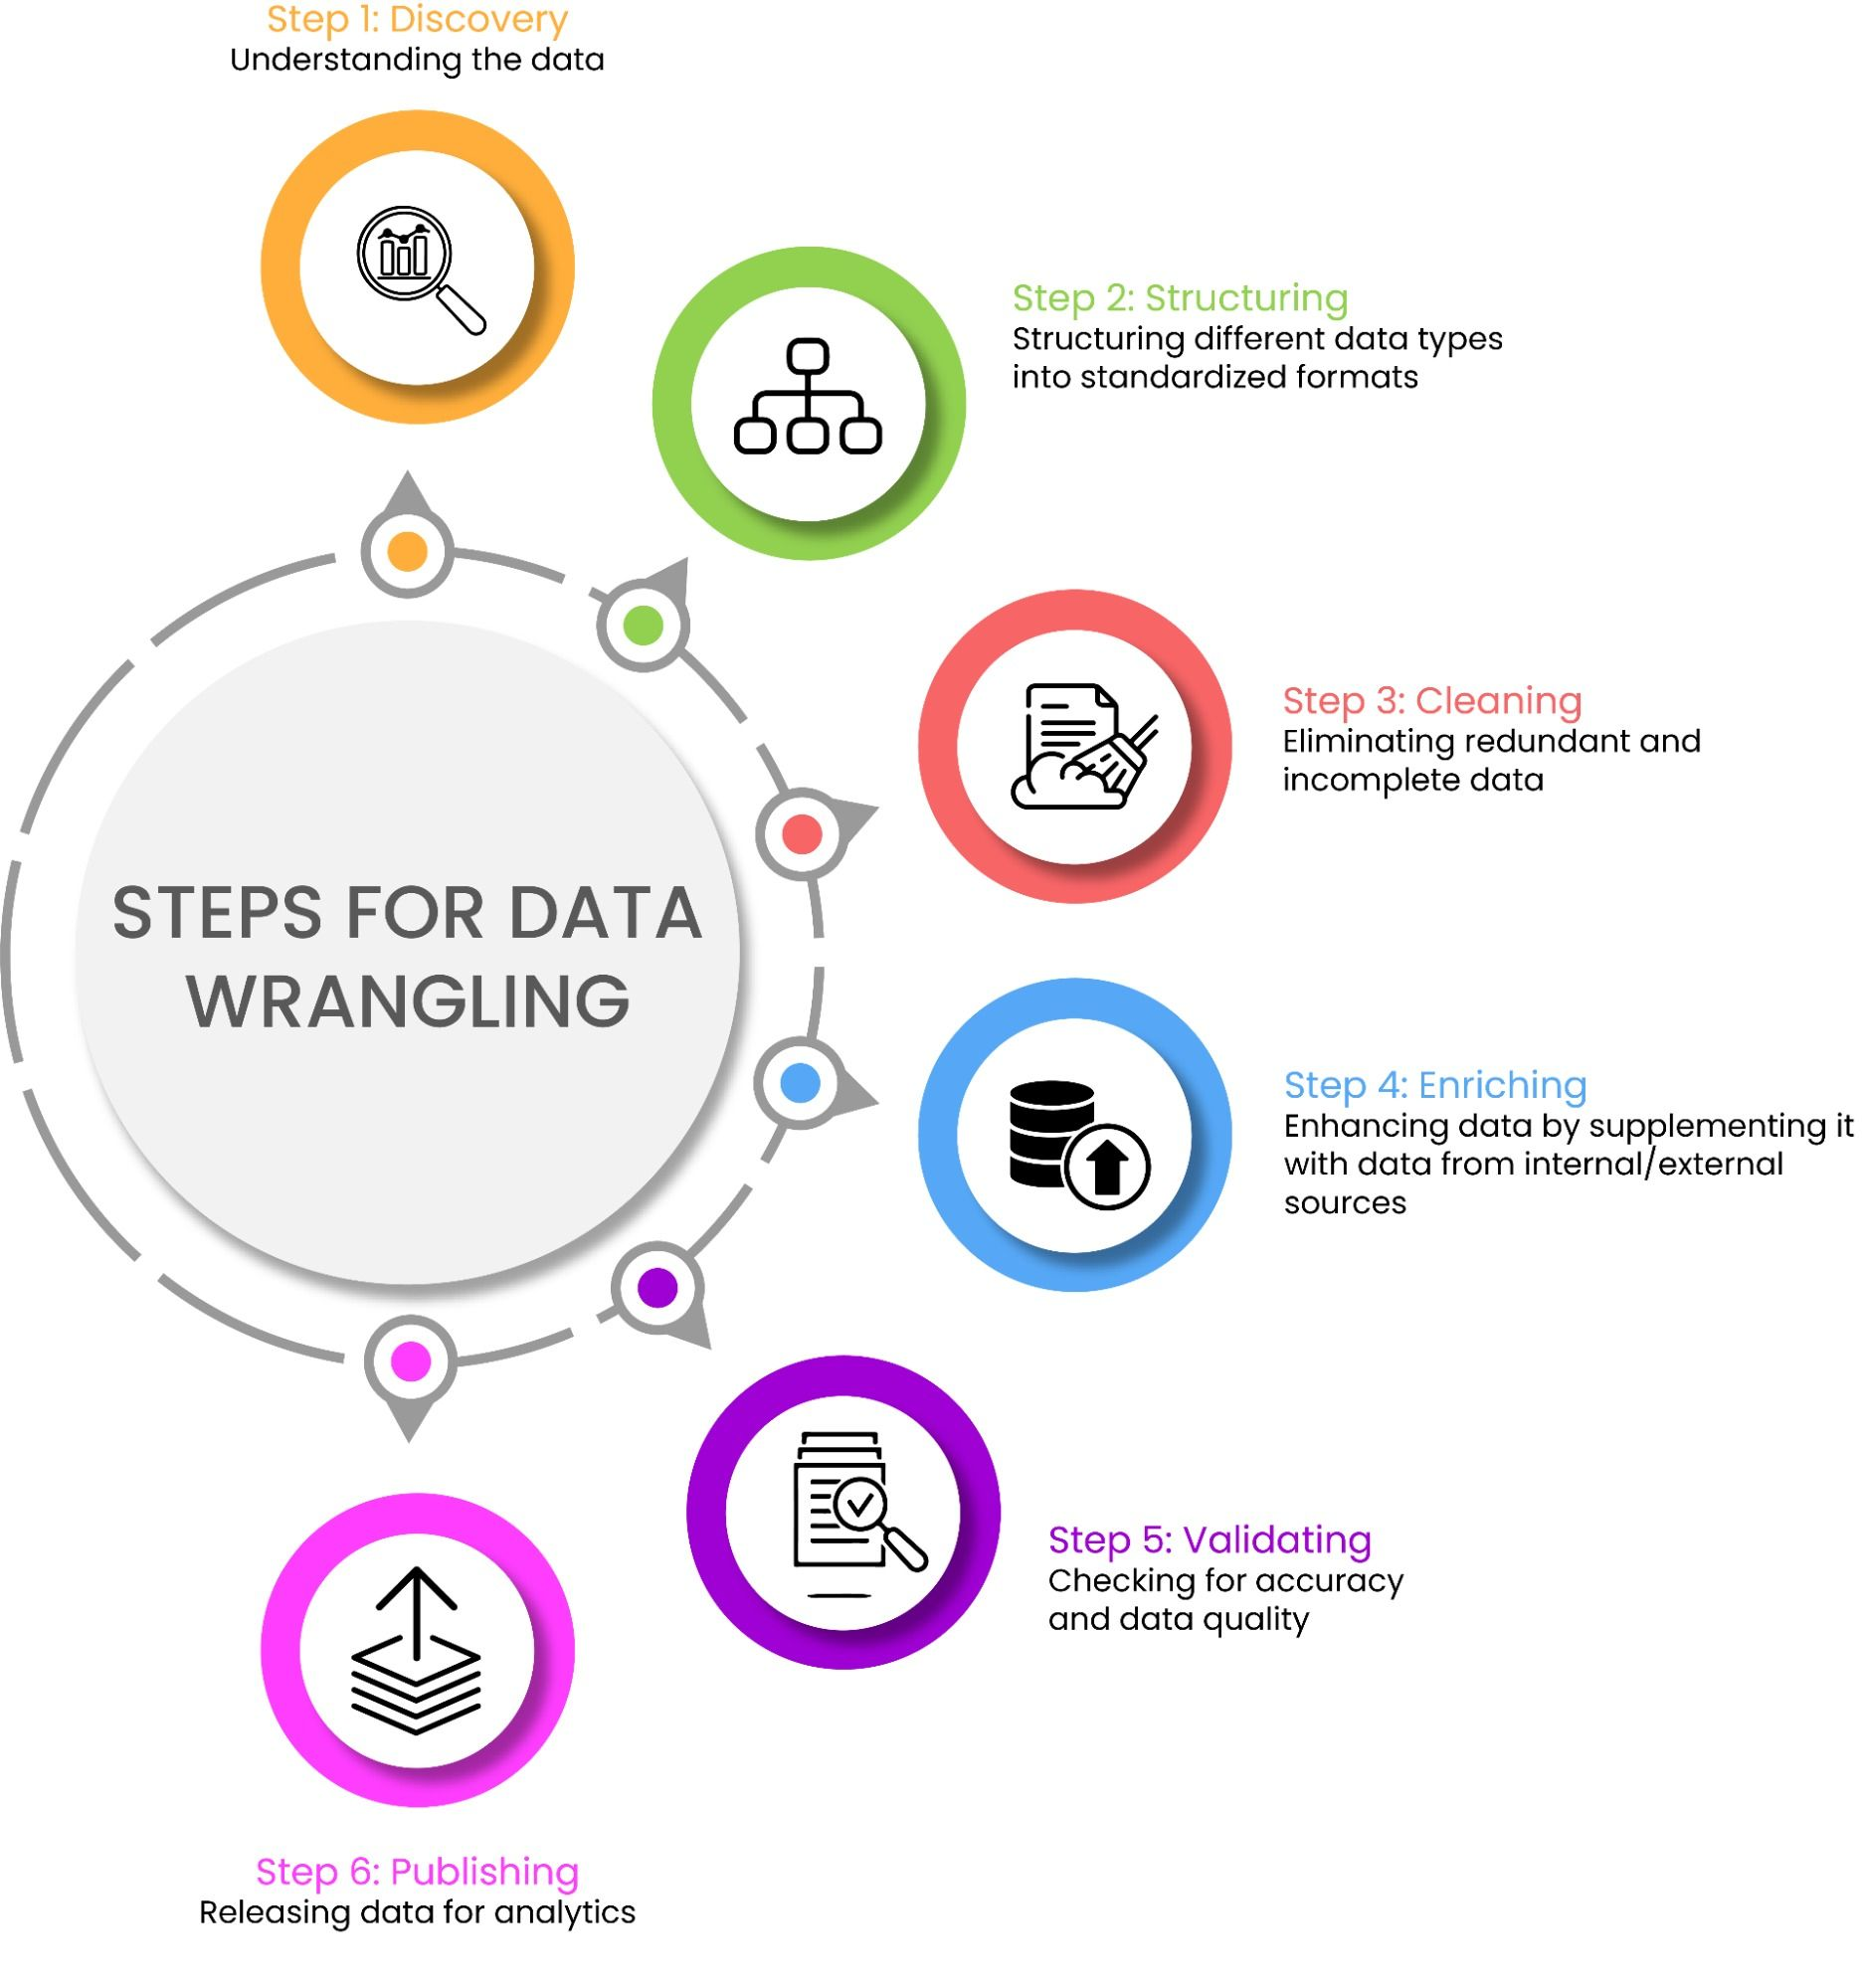

https://www.turing.com/kb/data-wrangling-and-importing-csv-in-python

https://online.hbs.edu/blog/post/data-wrangling

# Data Transformation

https://www.analyticsvidhya.com/blog/2021/05/feature-transformations-in-data-science-a-detailed-walkthrough/#:~:text=What%20is%20Feature%20Transformation%3F,2.

#Visulaization

##References


* https://docs.google.com/spreadsheets/d/1vbLyD_76IRyjtTyDtzX85E9LwkWsRKs3wvCOp0fOaVw/edit?usp=sharing

* https://inferentialthinking.com/

## Trying out the Book - https://inferentialthinking.com/

In [ ]:
import urllib.request
huck_finn_url = 'https://www.inferentialthinking.com/data/huck_finn.txt'
with urllib.request.urlopen(huck_finn_url) as response:
   html = response.read()
url_text=html.decode("utf-8")

In [ ]:
print(url_text)

In [ ]:
temp1=url_text.split('CHAPTER')
listOfChapters=[xx.split('--')[0] for xx in temp1[1:43]]
chapters={xx:'\r\n\r\n'.join(temp1[44+kk].split('\r\n\r\n')[1:]) for kk,xx in enumerate(listOfChapters)}
numberOfCounts={yy: {xx:np.char.count(chapters[xx], yy) for xx in [*chapters]} for yy in ['Jim','Tom','Huck']}
cumulativeNumberOfCounts={xx:np.cumsum([numberOfCounts[xx][yy] for yy in [*numberOfCounts[xx]]]) for xx in [*numberOfCounts]}

In [ ]:
import plotly.graph_objects as go

# Create random data with numpy
xValues=[*chapters]

yValuesList=[cumulativeNumberOfCounts[xx] for xx in [*cumulativeNumberOfCounts]]
fig = go.Figure()

# Add traces
for ii,yValues in enumerate(yValuesList):
    fig.add_trace(go.Scatter(x=xValues, y=yValues,
                        mode='lines+markers',
                        name=[*cumulativeNumberOfCounts][ii]))

fig.show()

#Template Examples

###Histogram

In [ ]:
#User inputs - Drop down menus
histGpCol=None # Pick from drop down list [None]+categoryCols
histPltCol='people_fully_vaccinated' #'new_cases' # Pick from drop down list [None]+categoryCols
histPltValCol='people_fully_vaccinated' #'new_cases' #'people_vaccinated' #'total_deaths' #'icu_patients_per_million' #'total_boosters_per_hundred' #None # Pick from drop down list [None]+valueCols

In [ ]:
#Python code
#histGpFldList=list(set(importDataPDF[histGpCol].to_list()))
#histGpFldList.sort()
histPltFldList=list(set(importDataPDF[histPltCol].to_list()))
histPltFldList.sort()
histPlotDataPDF[histPltValCol]=[float(xx) for xx in importDataPDF[histPltValCol].to_list()] #[importDataPDF[histPltCol].isin(histPltFldList)]

In [ ]:
binRange=[min([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()]),max([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()])]
binSize=int((binRange[1]-binRange[0])/10)+1
xLabelHist=histPltValCol
yLabelHist='Numbers'
histTitle=histPltValCol
figHist=hist_plot(False, histPlotDataPDF, binRange, binSize, histGpCol, histPltValCol, histTitle, xLabelHist, yLabelHist)

In [ ]:
figHist.show()

###Bar Plots

In [ ]:
#User inputs - Drop down menus
barGpCol=None #'continent' #None #None # Pick from drop down list [None]+categoryCols
barPltCol='location' # Pick from drop down list [None]+categoryCols
barPltValCol='people_vaccinated'#'gdp_per_capita' #'icu_patients_per_million' #'total_boosters_per_hundred' #None # Pick from drop down list [None]+valueCols
ifBarPltAverage=False #True #

In [ ]:
#Python code
barPlotDataPDF=importDataPDF

In [ ]:
xLabel=barPltCol
if barPltValCol==None:
  yLabel='Numbers'
else:
  if ifBarPltAverage:
    yLabel='Average '+barPltValCol
  else:
    yLabel=barPltValCol

titleText=yLabel+' vs '+xLabel+': legend indicates - '+str(barGpCol)
figGpBar=grouped_bar_graphs(barPlotDataPDF, barGpCol, barPltCol, barPltValCol, ifBarPltAverage, xLabel, yLabel, titleText, 'stack')

In [ ]:
figGpBar.show()

### Pie plot

In [ ]:
#User inputs - Drop down menus
pieGpCol='continent' #None #'location'# Pick from drop down list [None]+categoryCols
piePltCol='location' # Pick from drop down list [None]+categoryCols
piePltValCol='new_deaths_per_million' #'total_deaths' #'icu_patients_per_million' #'total_boosters_per_hundred' #None # Pick from drop down list [None]+valueCols

In [ ]:
#Python code
#pieGpFldList=list(set(importDataPDF[pieGpCol].to_list()))
#pieGpFldList.sort()
piePltFldList=list(set(importDataPDF[piePltCol].to_list()))
piePltFldList.sort()
piePlotDataPDF=importDataPDF #[importDataPDF[piePltCol].isin(piePltFldList)]

In [ ]:
ifAverage=True
if ifAverage:
  pieTitle='Average '+piePltValCol
else:
  pieTitle=piePltValCol
figDistPie=pi_plot_values(piePlotDataPDF, pieGpCol, piePltValCol, ifAverage, pieTitle)

In [ ]:
figDistPie.show()

### Bubble Scatter plot

In [ ]:
#User inputs - Drop down menus
pointCol='date'#'location' #Pick from drop down list categoryCols
yplotCol='new_deaths_per_million' #'new_cases_per_million' #'new_cases' #'total_deaths' #'icu_patients_per_million' #'total_deaths_per_million' #Pick from drop down list categoryCols
ifBubbleAverage_y=False #
xplotCol='people_fully_vaccinated_per_hundred' #'new_deaths' #'date' #'people_fully_vaccinated' #'human_development_index' #'people_vaccinated' #'icu_patients_per_million'  #Pick from drop down list categoryCols
ifBubbleAverage_x=False #True #
zplotCol='total_cases_per_million' #'new_deaths_per_million' #'people_fully_vaccinated' #'population' #Pick from drop down list categoryCols
ifBubbleAverage_z=False #

In [ ]:
#User inputs - Drop down menus
pointCol='location' #'date'#Pick from drop down list categoryCols
yplotCol='new_deaths_per_million' #'new_cases_per_million' #'new_deaths_per_million' #'new_cases_per_million' #'new_cases' #'total_deaths' #'icu_patients_per_million' #'total_deaths_per_million' #Pick from drop down list categoryCols
ifBubbleAverage_y=True #
xplotCol='human_development_index' #'people_fully_vaccinated_per_hundred' #'new_deaths' #'date' #'people_fully_vaccinated' #'human_development_index' #'people_vaccinated' #'icu_patients_per_million'  #Pick from drop down list categoryCols
ifBubbleAverage_x=True #True #
zplotCol='people_fully_vaccinated_per_hundred' #'population_density'#'new_cases_per_million' #'population_density' #'total_cases_per_million' #'people_fully_vaccinated' #'population' #Pick from drop down list categoryCols
ifBubbleAverage_z=True

In [ ]:
#Python code
bubbleDataPDF=importDataPDF #[importDataPDF[pointCol].isin(bubblePltFldList)]
groupCol='continent' #'location'
xvalueCol=xplotCol  # Pick from drop down list [None]+valueCols
yvalueCol=yplotCol # Pick from drop down list [None]+valueCols
zvalueCol=zplotCol # Pick from drop down list [None]+valueCols
figTitleBubble=pointCol+' wise '+str(yplotCol)+' vs '+str(xplotCol)+' - bubble size indicates '+str(zplotCol) #Input text
xLabelBubble=xplotCol
yLabelBubble=yplotCol #'Average '+yplotFld #'y-label' #Input text
figBubble=bubble_scatter_plot_values(bubbleDataPDF,groupCol,pointCol,xvalueCol,yvalueCol,zvalueCol,ifBubbleAverage_x,ifBubbleAverage_y,ifBubbleAverage_z,figTitleBubble,xLabelBubble,yLabelBubble)

In [ ]:
np.log(10)

In [ ]:
importDataPDF

In [ ]:
figBubble.show()

###Displaying plots

In [ ]:
figGpBar.show()
figHist.show()
figDistPie.show()
figBubble.show()

# Gaussian Mean Clustering

Consider a probability space $(\Omega,\mathcal{F},\mu)$ and 
let $X:\Omega \mapsto \mathbb{R}^m$ be a random variable.
Define the $\mathcal{F}$ measurable random variable $C: \Omega \mapsto \left\{1,2,\cdots,k\right\}$  on $(\Omega,\mathcal{F})$ such that $\mathcal{C}_i=C^{-1}(i)$ partitions $\Omega$ into disjoint sets. Let $c_i\triangleq P(\mathcal{C}_i)$ denote the probability density distribution of $C$. 
The problem we have is the one of figuring out if for a random choice $\omega\in \Omega$ the only information we have is the corresponding value of the random variable, $X(\omega)=x$, what is the probability of $\omega\in \mathcal{C}_i$. That is how can we estimate $p_\mu(C=i\mid X=x)$. 
If we also know $p_\mu(X\mid C)$ then from the Baye's rule we know
\begin{align*}
p_\mu(C\mid X)= \frac{p_\mu(X\mid C)p_\mu(C)}{p_\mu(X)}
\end{align*}
or more specifically
\begin{align*}
p_\mu(C=i\mid X=x)= \frac{c_i\,p_\mu(x\mid C=i)}{p_\mu(X=x)}.
\end{align*}
Since $ C^{-1}(i)\cap C^{-1}(j)=\emptyset$ for $i\neq j$ we have that
$X^{-1}(x)=\cup_{i=1}^k \left(X^{-1}(x)\cap C^{-1}(i)\right)$ and hence 
\begin{align*}
p_\mu(X=x)&=p_\mu\left(\cup_{i=1}^k \left(X^{-1}(x)\cap C^{-1}(i)\right)\right)=\sum_{i=1}^k p_\mu\left(X^{-1}(x)\cap C^{-1}(i)\right)\\
&=\sum_{i=1}^k p_\mu\left(X^{-1}(x)\mid C^{-1}(i)\right)\,p_\mu\left(C^{-1}(i)\right)=\sum_{i=1}^kc_i\,p_\mu(x\mid C=c_i).
\end{align*}
Thus we have
\begin{align}
p_\mu(C=i\mid X=x)= \frac{c_i\,p_\mu(x\mid C=i)}{\sum_{i=1}^kc_i\,p_\mu(x\mid C=i)}.
\end{align}
We will say that for a given random $\omega$, if $X(\omega)=x$, then that $\omega$ is in a cluster $C=i$ if $p_\mu(C=i\mid X=x)>p_\mu(C=j\mid X=x)\:\:\:\forall \:\:\: j\neq i$. 

In a typical clustering problem what we know is only a sequence of values $\{x_1,x_2,\cdots,x_n\}$ that $X$ has taken. We also typically do not know the probabilities $p_\mu(C)=c_i$ or the distribution $p_\mu(X\mid C=c_i)$. 

Let us consider the problem of estimating $p_\mu(C=i)=c_i$ and $p_\mu(X\mid C=c_i)$ given a set of data $\{x_1,x_2,\cdots,x_n\}$. We will assume that this data is generated by a set of independent and identically distributed random variables $\{X_1,X_2,\cdots,X_n\}$ with mean and variance equal to that of $X$.

The clustering problem is then to find $p_\mu(C=i)=c_i$ and the distributions $p_\mu(X\mid C=c_i)$ such that the sample $\{x_1,x_2,\cdots,x_n\}$ we have has a maximum likely hood of occurring. That is to find $p_\mu(C=i)=c_i$ and $p_\mu(X\mid C=i)$ such that 
\begin{align*}
p(x_1,x_2,\cdots,x_n)= \prod_{i=1}^np_\mu(x_i),
\end{align*}
is a maximum.
Typically one assumes a model for $p_\mu(X\mid C=i)$ and finds the parameters of the model and the $c_i$ such that $p(x_1,x_2,\cdots,x_n)$ is maximized. This algorithm is referred to as the \textit{expectation maximization algorithm}. 


When the conditional probability density $p_\mu(X\mid C=c_i)$ is assumed to be a $m$-dimensional multivariate gaussian parameterized by the mean $\mu_i$ and covariance $\Sigma_i$ the clustering that one obtains is called a \emph{Gaussian Mean Mixture} clustering. That is in Gaussian Mean Mixture clustering we assume
\begin{equation}
p_\mu(X=x\mid C=c_i)=\frac{1}{\sqrt{(2\pi)^{m}|\Sigma_i|}}\exp{\left(-\frac{(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)}{2}\right)},
\end{equation}
where $|\Sigma_i|$ is the determinant of $\Sigma_i$.
Then
\begin{align*}
p(x_1,x_2,\cdots,x_n)=\prod_{i=1}^n\sum_{j=1}^k\frac{c_j}{\sqrt{(2\pi)^{m}|\Sigma_j|}}\exp{\left(-\frac{(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2}\right)}.
\end{align*}
Expectation maximization algorithm then finds $\{c_j,\mu_j,\Sigma_j\}$ such that 
$p(x_1,x_2,\cdots,x_n)$ is maximized.


# Gaussian Process Regression

 Let ${G}$ be some set. Consider a one dimensional Gaussian process $X_g\sim \mathcal{N}(\mu_g,\kappa(g,g))$ where $g\in G$ and $\kappa:G\times G \mapsto \mathbb{R}$ is the auto-correlation function $E\left((X_g-\mu_g)(X_{g'}-\mu_{g'})\right)=\kappa(g,g')$. Let $Y_g$ be another stochastic process that satisfies
\begin{align}
Y_g&=X_g+\nu,
\end{align}
where $\nu\sim \mathcal{N}(\mu,\sigma_m)$.
This represents a noisy sampling of $X_g$. If one samples the stochastic process $Y_g$ at different $g$ and have the set of observations ${y}_{n}\triangleq [y_{g_1},y_{g_2},\cdots,y_{g_n}]^T$, the Gaussian Process (GP) regression is the problem of estimating $Y_g$ given the observations $y_n$.


Consider the multidimensional random variable
$\mathcal{Y}_n\triangleq[Y_{g_1},Y_{g_2},\cdots,Y_{g_n}]^T$ and $\mathcal{X}_n\triangleq[X_{g_1},X_{g_2},\cdots,X_{g_n}]^T$. Then $\mathcal{Y}_n\sim  \mathcal{N}(\mu_n,K_n+\sigma_m^2I)$ where, $\mu_n\triangleq[\mu_{g_1}+\mu,\mu_{g_2}+\mu,\cdots,\mu_{g_n}+\mu]^T$ and $K_n$ is the $n\times n$ auto-correlation matrix 
\begin{align*}
K_n&\triangleq E\left((\mathcal{X}_n-\mu_n)(\mathcal{X}_n-\mu_n)^T\right)=
\begin{bmatrix}
\kappa(g_1,g_1) & \kappa(g_1,g_2) & \cdots & \kappa(g_1,g_n)\\
\vdots & \vdots & \vdots &\vdots\\
\kappa(g_n,g_1) & \kappa(g_n,g_2) & \cdots & \kappa(g_n,g_n)
\end{bmatrix}.
\end{align*}
Thus the Gaussian Process (GP) regression problem boils down to finding $p(Y_{g}|\mathcal{Y}_n={y}_{n})$. We see that
\begin{align*}
p\left(\begin{array}{c} Y_{g}\\ \mathcal{Y}_n
\end{array}\right)=\mathcal{N}\left(\begin{bmatrix}  \mu_{g}+\mu \\ \mu_n
\end{bmatrix},\begin{bmatrix} \kappa(g,g) & k^T \\ k & K_n \end{bmatrix}+\sigma^2_m
I\right).
\end{align*}
where $k=[\kappa(g_1,g), \kappa(g_2,g), \cdots, \kappa(g_{n},g)]^T$.
Let $p(Y_{g}\mid \mathcal{Y}_n=y_n)\sim \mathcal{N}(\widehat{\mu}_{g},\sigma^2_{g})$. From the properties of normal distributions (please refer to \cite{} for formulas for constructing the conditional probabilities of Gaussian distributions) we find that
\begin{align}
\widehat{\mu}_{g}&=\mu_{g}+\mu+k^T (K_n+\sigma^2_mI)^{-1}(y_n-\mu_n),\\
\sigma^2_{g}&= \sigma^2_m+\kappa(g,g)-k^T (K_n+\sigma^2_mI)^{-1}k.
\end{align}
Thus the GP regression problem boils down to finding the appropriate auto-correlation function $\kappa(g,g')$.

The information gain 
\begin{align*}
I(Y_g;\mathcal{Y}_n)&=H({Y}_g)-H(Y_g|\mathcal{Y}_n)\\
&=\frac{1}{2}\log{\left(2\pi e(\kappa(g,g)+\sigma_m^2)\right)}-\frac{1}{2}\log{\left(2\pi e(\sigma^2_m
+\kappa(g,g)-k^T (K_n+\sigma^2_mI)^{-1}k)\right)}\\
&=\frac{1}{2}\log{\left(\frac{\kappa(g,g)+\sigma_m^2}{\sigma^2_m
+\kappa(g,g)-k^T (K_n+\sigma^2_mI)^{-1}k}\right)}.
\end{align*}


## Linear regression

###GP - Approach

Consider the stochastic process defined above and let $G=\mathbb{R}^n$,  $\nu\sim \mathcal{N}(0,\sigma_m^2I)$, and $X_g=g^Tw$ for $w\sim\mathcal{N}(\mu_w,\sigma_w^2I)$. Then $\kappa(g,g')=g^T\Sigma_wg'$ and the above expression becomes
\begin{align}
Y_g&=X_g+\nu=g^Tw+\nu.
\end{align}
The GP regression problem reduces in this case to that of the linear regression problem and the above expressions reduce to
\begin{align}
\widehat{\mu}_{g}&=\mu_w+k^T (K_n+\sigma^2_mI)^{-1}(y_n-\mu_n),\\
\sigma^2_{g}&= \sigma^2_m+\kappa(g,g)-k^T (K_n+\sigma^2_mI)^{-1}k.
\end{align}


### Bayesian - Approach

Consider a set of data $\{y_i=y(g_i)\}$ where $G=\mathbb{R}^n$. We will attmpt to model the data by a random process
\begin{align}
Y_g&=g^Tw,
\end{align}
where $X_g=g^Tw$ for $w$ some random variable. 
\begin{align}
\mathcal{P}(w\,|\,\{Y_g=y_g\})&\propto\mathcal{P}(\{Y_g=y_g\}\,|\,w)\mathcal{P}(w).
\end{align}

If we assume $w\sim\mathcal{N}(\mu_w,\Sigma_w)$ then from properties of conditional normal distributions 
\begin{align*}
p\left(\begin{array}{c}  w \\ \mathcal{Y}_n
\end{array}\right)=\mathcal{N}\left(\begin{bmatrix}  \mu_w \\ \mu_n
\end{bmatrix},\begin{bmatrix} \kappa(g,g) & k^T \\ k & K_n \end{bmatrix}\right).
\end{align*}

\begin{align}
\mathbb{E}\left(\begin{bmatrix} w-\mu_w\\ \mathcal{Y}_n-\mu_n\end{bmatrix}\begin{bmatrix}(w-\mu_w)^T & (\mathcal{Y}_n-\mu_n)^T\end{bmatrix}\right)
\end{align}

Let $\mathcal{P}(w\mid \{\mathcal{Y}_n=y_n\})\sim \mathcal{N}(\widehat{\mu}_{w},\widehat{\Sigma}_{w})$. From the properties of normal distributions (please refer to \cite{} for formulas for constructing the conditional probabilities of Gaussian distributions) we find that

\begin{align}
\widehat{\mu}_{w}&=\mu_w+k^T K_n^{-1}(y_n-\mu_n),\\
\widehat{\Sigma}&= \Sigma_w-k^T K_n^{-1}k.
\end{align}
where
\begin{align}
k&=E\left((\mathcal{Y}_n-\mu_n)(w-\mu_{w})^T\right)=\begin{bmatrix}g_1^T\\\vdots\\ g_n^T\end{bmatrix}E\left((w-\mu_{w})(w-\mu_{w})^T\right)=\begin{bmatrix}g_1^T\\\vdots\\ g_n^T\end{bmatrix}\Sigma_w.
\end{align} 
and 
\begin{align}
({K_n})_{ij}=E\left((Y_{g_i}-\mu_{g_i})(Y_{g_j}-\mu_{g_j})\right)=g_i^T\Sigma_wg_j
\end{align}

# Principle Component Analysis

Consider an observation that is characterized by a $m$-dimensional random variable
\begin{align}
X&\triangleq \begin{bmatrix} X_{1} & X_{2} & \cdots & X_{m}
\end{bmatrix}^T.
\end{align}



Let 
\begin{align}
\mathbb{E}(XX^T)=U\Sigma V^*
\end{align}
where $(U,\Sigma,V^*)$ is the SVD of $\mathbb{E}(XX^T)$.

Define $Z\triangleq U^*X$ and $F\triangleq V^*X$ then 
\begin{align}
\mathbb{E}(ZF^T)=\Sigma
\end{align}
\begin{align}
XF^T=U\Sigma
\end{align}

Thus 
\begin{align}
\mathbb{E}(FF^T)=\mathbb{E}(V^*XX^TV)=V^*\mathbb{E}(XX^T)V=V^*U\Sigma=\Sigma
\end{align}

# Factor Analysis

Let $Z$ be $m$-dimensional continuous or discrete valued random variable with zero mean and covariance $E(ZZ^T)=I_{m\times m}$. We seek to find $\Lambda_{mk}$ and a reduced $k$-dimensional random variable $F$ such that
\begin{align*}
Z=\Lambda F+\epsilon,
\end{align*}
where $\epsilon$ is a $m$-dimensional random variable with zero mean, $E(\epsilon \epsilon^T)=\Sigma_{\epsilon}$, and $E(\epsilon F^T)=0$.  We additionally impose the condition that $E(FF^T)=I_{k\times k}$.

The condition $E(\epsilon F^T)=0$ implies that
\begin{align*}
E(ZF^T)=\Lambda.
\end{align*}
Also
\begin{align*}
E(ZZ^T)=\Lambda\Lambda^T+E(\epsilon\epsilon^T)\\
E(z_iz_j)=\sum_{r=1}^k\lambda_{ir}\lambda_{jr}+E(\epsilon_{i}\epsilon_j)
\end{align*}
Thus in particular
\begin{align*}
E(z_i^2)=\sum_{r=1}^k\lambda_{ir}^2+E(\epsilon_{i}^2)=1,
\end{align*}
where the last inequality occurs due to the fact that $Z$ is normalized.

Let 
\begin{align*}
h_i^2&\triangleq \sum_{r=1}^k\lambda_{ir}^2,\\
\varphi_i^2&\triangleq 1-\sum_{r=1}^k\lambda_{ir}^2=1-h_i^2=E(\epsilon_{i}^2).
\end{align*}
The parameter $h_i^2$ is called the \emph{communality} of $z_i$ and the parameter $\varphi_i^2=E(\epsilon_{i}^2)$ is called the \emph{uniqueness} of $z_i$.  

Since $E(z_if_j)=\lambda_{ij}$ we see that if $\varphi_i^2\approx 1$ then it indicates that $z_i$ has very little correlation with $F$ and if $h_i^2\approx 1$ then it indicates that $z_i$ has very strong correlation with $F$ and hence with the rest of the $z_j$ as well.



# Multi Attribute Value Technique

Let $v_i\triangleq v(X_i)$ be function of the random variable $X_i$. Define
\begin{align*}
w_i&\triangleq \frac{E(v(X_i))}{\sum_{j=1}^m E(v(X_j))},\\
Q&\triangleq \sum_{i=1}^m w_i E(v(X_i))=\frac{1}{\sum_{j=1}^m E(v(X_j))}\sum_{i=1}^m E(v(X_i))^2
\end{align*}


# Q-Learning

Let the random variable $s_t\in \mathcal{S}$ be the state and the random variable $a_t\in \mathcal{A}$ be the action. An outcome of a system is a realisation of $\tau=(s_0,a_0,s_1,a_1,\cdots)$. 
A policy is a probability distribution $\pi(a_t\,|\,s_t)$ that represents the probability of agent taking action $a_t$ given that she is in state $s_t$. The states of the system evolve according to a Markov process. That is
\begin{align}
P(s_{t+1}\,|\,s_t,a_{t},\cdots,s_0,a_0)=P(s_{t+1}\,|\,s_t,a_{t})
\end{align}
At each time $t$ the reward is a function of the current state and possibly the previous action and the state. That is, the reward at time $t$ is a function 
$r(s_t, s_{t-1}, a_{t-1})$.


The objective of RL is to find the optimal policy, $\pi^*$ such that
\begin{align}
\pi^*=\arg\max_{\pi}\mathbb{E}_\pi\left(\sum_{t=0}^\infty \gamma^tr(s_{t+1},s_t,a_t)
\right).
\end{align}

Note that
\begin{align*}
p_\pi(s_t,a_t,s_{t+1},a_{t+1},\cdots)&=p_\pi(s_{t+1},a_{t+1},\cdots\,|\,s_{t},a_{t})p_\pi(s_{t},a_{t})=p_\pi(s_{t+1},a_{t+1},\cdots\,|\,s_{t},a_{t})\pi(a_{t}\,|\,s_{t})p(s_{t})\\
&=p_\pi(s_{t+2},a_{t+2},\cdots\,|\,s_{t+1},a_{t+1},s_t,a_t)p_\pi(s_{t+1},a_{t+1}\,|\,s_{t},a_{t})\pi(a_{t}\,|\,s_{t})p(s_{t})\\
&=p_\pi(s_{t+2},a_{t+2},\cdots\,|\,s_{t+1},a_{t+1},s_t,a_t)p(s_{t+1}\,|\,s_{t},a_{t})\pi(a_{t+1}\,|\,s_{t+1},s_{t},a_{t})\pi(a_{t}\,|\,s_{t})p(s_{t})\\
&=p(s_{t})\prod_{k=0}^\infty p(s_{t+1+k}\,|\,s_{t+k},a_{t+k})\pi(a_{t+k}\,|\,s_{t+k})
\\
&=p(s_{t})p(s_{t+1}\,|\,s_{t},a_{t})\pi(a_{t}\,|\,s_{t})\prod_{k=0}^\infty p(s_{t+2+k}\,|\,s_{t+1+k},a_{t+1+k})\pi(a_{t+1+k}\,|\,s_{t+1+k})\\
&=p(s_{t})p(s_{t+1},a_{t}\,|\,s_{t})\prod_{k=0}^\infty p(s_{t+2+k}\,|\,s_{t+1+k},a_{t+1+k})\pi(a_{t+1+k}\,|\,s_{t+1+k})\\
&=p(s_{t+1},s_{t},a_{t})\prod_{k=0}^\infty p(s_{t+2+k}\,|\,s_{t+1+k},a_{t+1+k})\pi(a_{t+1+k}\,|\,s_{t+1+k})
\end{align*}
This shows that
\begin{align*}
p_\pi(a_t,s_{t+1},a_{t+1},\cdots\,|\, s_t=s)&=\prod_{k=0}^\infty p(s_{t+1+k}\,|\,s_{t+k},a_{t+k})\pi(a_{t+k}\,|\,s_{t+k})
\end{align*}

Define the value function to be the value of the expected discounted cumulative future reward when one starts at $s_t=s$
\begin{align}
V^\pi(s)\triangleq \mathbb{E}_\pi\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\,\right|\,s_t=s\right)
\end{align}

We see that
{\tiny
\begin{align*}
V^\pi(s)&=\mathbb{E}_\pi\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\right|\, s_t=s\right)\\
&=\sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\right|\, s_t=s\right)p_\pi(a_t,s_{t+1},a_{t+1},\cdots\,|\,s_t=s)\\
&=\sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\right|\, s_t=s\right)p(s_{t+1}\,|\,s_{t}=s,a_{t})\pi(a_{t}\,|\,s_{t}=s)\prod_{i=0}^\infty p(s_{t+2+i}\,|\,s_{t+1+i},a_{t+1+i})\pi(a_{t+1+i}\,|\,s_{t+1+i})\\
&=\sum_{\tau}\left(r(s_{t+1},s_{t}=s,a_{t})+\gamma\sum_{k=0}^\infty \gamma^kr(s_{t+2+k},s_{t+1+k},a_{t+1+k})\right)p(s_{t+1}\,|\,s_{t}=s,a_{t})\pi(a_{t}\,|\,s_{t}=s)\prod_{i=0}^\infty p(s_{t+2+i}\,|\,s_{t+1+i},a_{t+1+i})\pi(a_{t+1+i}\,|\,s_{t+1+i})\\
&=\sum_{s',a}p(s'\,|\,s,a)\pi(a\,|\,s)\left(r(s',s,a)+\gamma \sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+2+k},s_{t+1+k},a_{t+1+k})\,\right|\,s_{t+1}=s'\right)\prod_{i=0}^\infty p(s_{t+2+i}\,|\,s_{t+1+i},a_{t+1+i})\pi(a_{t+1+i}\,|\,s_{t+1+i})
\right)\\
&=\sum_{s',a}p(s'\,|\,s,a)\pi(a\,|\,s)\left(r(s',s,a)+\gamma \sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+2+k},s_{t+1+k},a_{t+1+k})\,\right|\,s_{t+1}=s'\right)p_\pi(a_{t+1},s_{t+2},a_{t+2},\cdots\,|\,s_{t+1}=s')
\right)\\
&=\sum_{s',a}p(s'\,|\,s,a)\pi(a\,|\,s)\left(r(s',s,a)+\gamma V^\pi(s')
\right)\\
&=\sum_{a}\pi(a\,|\,s)\sum_{s'}p(s'\,|\,s,a)\left(r(s',s,a)+\gamma V^\pi(s')
\right)
\end{align*}
}
This yields that
\begin{align*}
V^\pi(s)= \mathbb{E}_\pi\left(\left. r(s_{t+1},s_{t},a_{t})+\gamma V^\pi(s_{t+1})\,\right|\,s_t=s\right)
\end{align*}


Define the Q-Action value function to be the value of the expected discounted cumulative future reward when one starts at $s_t=s,a_t=a$
\begin{align}
Q^\pi(s,a)\triangleq \mathbb{E}_\pi\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\,\right|\,s_t=s,a_t=a\right)
\end{align}

Note that
\begin{align*}
p_\pi(s_t,a_t,s_{t+1},a_{t+1},\cdots)&=p_\pi(s_{t+1},a_{t+1},\cdots\,|\,s_{t},a_{t})p(s_{t},a_{t})\\
&=p_\pi(s_{t+2},a_{t+2},\cdots\,|\,s_{t+1},a_{t+1},s_t,a_t)p_\pi(s_{t+1},a_{t+1}\,|\,s_{t},a_{t})p(s_{t},a_{t})\\
&=p_\pi(s_{t+2},a_{t+2},\cdots\,|\,s_{t+1},a_{t+1},s_t,a_t)p(s_{t+1}\,|\,s_{t},a_{t})\pi(a_{t+1}\,|\,s_{t+1},s_{t},a_{t})p(s_{t},a_{t})\\
&=p(s_{t},a_{t})\prod_{k=0}^\infty p(s_{t+1+k}\,|\,s_{t+k},a_{t+k})\pi(a_{t+1+k}\,|\,s_{t+1+k})
\end{align*}


We see that
{\tiny
\begin{align*}
Q^\pi(s,a)&=\mathbb{E}_\pi\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\right|\, s_t=s,a_t=a\right)\\
&=\sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\right|\, s_t=s,a_t=a\right)p_\pi(s_{t+1},a_{t+1},\cdots\,|\,s_t=s, a_t=a)\\
&=\sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+1+k},s_{t+k},a_{t+k})\right|\, s_t=s,a_t=a\right)p(s_{t+1}\,|\,s_{t}=s,a_{t}=a)\pi(a_{t+1}\,|\,s_{t+1})\prod_{i=0}^\infty p(s_{t+2+i}\,|\,s_{t+1+i},a_{t+1+i})\pi(a_{t+2+i}\,|\,s_{t+2+i})\\
&=\sum_{\tau}\left(r(s_{t+1},s_{t}=s,a_{t}=a)+\gamma\sum_{k=0}^\infty \gamma^kr(s_{t+2+k},s_{t+1+k},a_{t+1+k})\right)p(s_{t+1}\,|\,s_{t}=s,a_{t}=a)\pi(a_{t+1}\,|\,s_{t+1})\prod_{i=0}^\infty p(s_{t+2+i}\,|\,s_{t+1+i},a_{t+1+i})\pi(a_{t+2+i}\,|\,s_{t+2+i})\\
&=\sum_{s',a'}p(s'\,|\,s,a)\pi(a'\,|\,s')\left(r(s',s,a)+\gamma \sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+2+k},s_{t+1+k},a_{t+1+k})\,\right|\,s_{t+1}=s',a_{t+1}=a'\right)\prod_{i=0}^\infty p(s_{t+2+i}\,|\,s_{t+1+i},a_{t+1+i})\pi(a_{t+1+i}\,|\,s_{t+1+i})
\right)\\
&=\sum_{s',a'}p(s'\,|\,s,a)\pi(a'\,|\,s')\left(r(s',s,a)+\gamma \sum_{\tau}\left(\left.\sum_{k=0}^\infty \gamma^kr(s_{t+2+k},s_{t+1+k},a_{t+1+k})\,\right|\,s_{t+1}=s',a_{t+1}=a'\right)p_\pi(a_{t+1},s_{t+2},a_{t+2},\cdots\,|\,s_{t+1}=s',a_{t+1}=a')
\right)\\
&=\sum_{s',a'}p(s'\,|\,s,a)\pi(a'\,|\,s')\left(r(s',s,a)+\gamma Q^\pi(s',a')
\right)\\
&=\sum_{s'}p(s'\,|\,s,a)\left(r(s',s,a)+\gamma \sum_{a'}\pi(a'\,|\,s')Q^\pi(s',a')
\right)
\end{align*}
}
 This yields that
\begin{align}
Q^\pi(s,a)= \mathbb{E}_\pi\left(\left. r(s_{t+1},s_{t},a_{t})+\gamma V^\pi(s_{t+1})\,\right|\,s_t=s, a_t=a\right)
\end{align}

\begin{align}
V^\pi(s)&=\sum_{a}\pi(a\,|\,s)\sum_{s'}p(s'\,|\,s,a)\left(r(s',s,a)+\gamma V^\pi(s')
\right)\\
Q^\pi(s,a)&=\sum_{s'}p(s'\,|\,s,a)\left(r(s',s,a)+\gamma \sum_{a'}\pi(a'\,|\,s')Q^\pi(s',a')
\right)
\end{align}
From the above two it can be seen that
\begin{align}
V^\pi(s)&=\sum_{a}\pi(a\,|\,s)Q^\pi(s,a)\\
Q^\pi(s,a)&=\sum_{s'}p(s'\,|\,s,a)\left(r(s',s,a)+\gamma V^\pi(s')\right)
\end{align}

Define the optimal policy $\pi^*$ to be the policy that maximises the optimal value function simultaneously at all states. That is
\begin{align*}
\pi^*\triangleq \argmax_{\pi} V^\pi(s) \:\:\: \forall \:\:\: s\in \mathcal{S}.
\end{align*} 
Let $V^*(s)\triangleq V^{\pi^*}(s)$ be the optimal value function.
Similarly the optimal action value function is defined to be
$Q^*(s,a)\triangleq \max_{\pi}Q^{\pi}(s,a)$

\subsection{Maximum Entropy Policy}
\begin{align*}
V^\pi(s_t=s)&\triangleq  \mathbb{E}_\pi\left(\left.\sum_{k=0}^\infty \gamma^k r(s_{t+1+k},a_{t+1+k})\,\right|\, s_t=s\right)=\sum_{a}\pi(a\,|\,s)Q^\pi(s,a)\\
Q^\pi(s_t=s,a_t=a)&\triangleq  \mathbb{E}_\pi\left(\left.\sum_{k=0}^\infty \gamma^k r(s_{t+1+k},a_{t+1+k})\,\right|\, s_t=s,a_t=a\right)=\sum_{s'}p(s'\,|\,s,a)\left(r(s',s,a)+\gamma V^\pi(s')\right)
\end{align*}

\begin{align*}
p^t_\pi(s)&\triangleq \sum_{\tau, s_t=s}p(\tau\,|\,\pi)\\
p^t_\pi(s,a)&\triangleq \sum_{\tau, s_t=s,a_t=a}p(\tau\,|\,\pi)
\end{align*}

\begin{align*}
R^t\triangleq \mathbb{E}_\pi (V^\pi(s_t))=\sum_{s\in \mathcal{S}}p^t_\pi(s)V^\pi(s^t=s)
\end{align*}

\begin{align*}
J^\pi(s)=\lambda (V^*(s)-V^\pi(s))+\mu(1-\sum_a\pi (a\,|\,s))-k_B\sum_a\pi (a\,|\,s)\log{(\pi (a\,|\,s))}
\end{align*}

\begin{align*}
\pi^*\triangleq \argmax_{\pi} \sum -\pi(a_i\,|\,s_j)\log{(\pi(a_i\,|\,s_j))}+\lambda \left(\bar{r}-\sum r(s_j,a_i)p_\pi(s_j,a_i)\right)-\mu\left(1-\sum p_\pi(s_j,a_i)\right)
\end{align*}


#The Baysian State of Mind
https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/

Let $\{\theta_i\}$ be the iid random varible that takes values in $\{0,1\}$. Let $\rho$ be a random variable that takes values in $[0, 1]$. We will assume that $\mathcal{P}(\{\theta_n=1\}\,|\,\{ \rho=p\})=p$.

Let $\mathcal{Y}_n\triangleq \sum_{i=1}^n\theta_i$ be the random variable that takes values in $\{0,1,\cdots,n\}$. We are intesetsed in finding the conditional probability distribution
\begin{align}
\mathcal{P}( \rho \,|\, \mathcal{Y}_n).
\end{align}

From Baye's theorem we have 
\begin{align}
\mathcal{P}(\rho \,|\, \mathcal{Y}_n)&=\frac{\mathcal{P}(\mathcal{Y}_n \,|\,\rho)\mathcal{P}(\rho)}{\mathcal{P}(\mathcal{Y}_n)}.
\end{align}
We will assume that $\mathcal{P}(\{\theta_n=1\}\,|\,\{ \rho=p\})=p$ and $\mathcal{P}(\{\theta_n=0\}\,|\,\{ \rho=p\})=1-p$. Thus
\begin{align}
\mathcal{P}(\rho\in P \,|\, \{\mathcal{Y}_n=y_n\})
&\propto \int_Pp^{y_n}(1-p)^{n-y_n}\,dp
\end{align}
Thus by normalizing we have
\begin{align}
\mathcal{P}(\rho\in P \,|\, \left\{\mathcal{Y}_n=y_n\right\})
&= \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\int_P\:p^{\alpha-1}(1-p)^{\beta-1}\,dp,
\end{align}
where we have set $\alpha_n\triangleq y_n+1$ and $\beta_n \triangleq (n-y_n+1)$.
This is the beta distribution.

Then we have
\begin{align}
\mathbb{E}(\rho |\{\mathcal{Y}_n=y_n\})=\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\int_0^1\:p\,p^{\alpha-1}(1-p)^{\beta-1}\,dp=\frac{\alpha}{\alpha+\beta}=\frac{y_n+1}{n+2}
\end{align}


Observe that if $\lim_{n\to \infty}y_n/n=r$ then $\lim_{n\to \infty}\mathbb{E}(\rho |\{\mathcal{Y}_n=y_n\})=r$.

In [ ]:
import scipy.stats as stats

In [ ]:
dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.2, size=n_trials[-1])
dist = stats.beta
x = np.linspace(0, 1, 100)

In [ ]:
heads

11

In [ ]:
N=50
heads = data[:N].sum()
y = dist.pdf(x, 1+heads, N-heads+1)
yScatterFig=go.Figure()
yScatterFig.add_trace(go.Scatter(x=x, y=y,mode='lines',name='markers'))
yScatterFig.show()

In [ ]:
txtData=pd.read_csv('/content/drive/My Drive/txtmsgs.csv')['13'].to_list()
txtData=[13]+txtData

In [ ]:
import plotly.graph_objects as go
x=[i for i in range(len(txtData))]
y=txtData
figData = go.Figure()
figData.add_trace(go.Bar(name='Text Messages', x=x, y=y))
# Change the bar mode
figData.update_layout(barmode='stack')
figData.show()

In [ ]:
import plotly.figure_factory as ff

hist_data = [txtData]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

In [ ]:
poi = stats.poisson
lambdA = [1.5, 4.25, 15.0]
kk=[i for i in range(80)]

In [ ]:
poi1=poi.pmf(kk,lambdA[2])

In [ ]:
figHist=go.Figure()
figHist.add_trace(go.Histogram(x=txtData, histnorm='probability',xbins={'start':.0,'end':80,'size':1}))
figHist.add_trace(go.Scatter(y=poi1, x=x))

In [ ]:
poi1

Let $\{C_t\}_0^N$ be a set of independent random variables that have a Poisson distribution. We assume that $\mathcal{P}(C_t) \sim Poisson(\lambda_1)$ for $t<\tau$ and $\mathcal{P}(C_t) \sim Poisson(\lambda_2)$ for $t\geq \tau$. Let $C=[C_1,\cdots,C_N]$ and $c=[c_1,\cdots,c_N]$.

We belive that $\mathcal{P}(\lambda_1),\mathcal{P}(\lambda_2) \sim Exp(\alpha)$ and $\mathcal{P}(\tau)=1/N$

\begin{align}
\mathcal{P}(\tau,\lambda_1,\lambda_2\,|\,C)=\frac{\mathcal{P}(C\,|\,\tau,\lambda_1,\lambda_2)\mathcal{P}(\tau,\lambda_1,\lambda_2)}{\mathcal{P}(C)}
\end{align}

Thus
\begin{align}
\mathcal{P}(\tau,\lambda_1,\lambda_2\,|\,\{C=c\})=\frac{\mathcal{P}(\{C=c\}\,|\,\tau,\lambda_1,\lambda_2)\mathcal{P}(\tau,\lambda_1,\lambda_2)}{\mathcal{P}(C=c)}\propto \mathcal{P}(\{C=c\}\,|\,\tau,\lambda_1,\lambda_2)\mathcal{P}(\tau,\lambda_1,\lambda_2)
\end{align}

https://juanitorduz.github.io/intro_pymc3/

In [ ]:
count_data=txtData
n_count_data = len(count_data)

In [ ]:
!pip install pymc3

In [ ]:
import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0/np.mean(count_data)
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [ ]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [ ]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [ ]:
n_count_data

In [ ]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

In [ ]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [ ]:
figData = go.Figure()
figData.add_trace(go.Bar(name='Text Messages', x=x, y=y))
# Change the bar mode
figData.update_layout(barmode='stack')
figData.show()

In [ ]:
figHist=go.Figure()
figHist.add_trace(go.Histogram(x=lambda_1_samples, name='lambda_1', histnorm='probability',xbins={'start':.0,'end':80,'size':1}))
figHist.add_trace(go.Histogram(x=lambda_2_samples, name='lambda_2', histnorm='probability',xbins={'start':.0,'end':80,'size':1}))

In [ ]:
figHist=go.Figure()
figHist.add_trace(go.Histogram(x=tau_samples, name='tau', histnorm='probability',xbins={'start':.0,'end':80,'size':1}))

In [ ]:
url = "https://raw.githubusercontent.com/data-8/textbook/main/assets/data/top_movies_2017.csv"
dataset = pd.read_csv(url)

In [ ]:
dataset

In [ ]:
!pip install pymc3

In [ ]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

In [ ]:
data_generator.eval()

array(0)

In [ ]:
n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    

In [ ]:
fig=go.Figure()

In [ ]:
fig.add_trace(go.Histogram(x=samples,xbins={'start':0,'end':10,'size':0.5}))

### Bayesian Correlation Estimation
* https://online.ucpress.edu/collabra/article/3/1/25/112377/Bayesian-Inference-for-Correlations-in-the

* https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-3-5

#Felx-Robot Modeling Data

In [91]:
from sklearn import linear_model
#Uploading from google drive - Mugalan
#from google.colab import drive
#drive.mount('/content/drive')
#Mugalan
csvFilePath='/content/drive/My Drive/ME Dept/E17_Group_Project/{}'
columns=['Input1','Input2','Input3','Input4','Output1','Output2','Output3','Output4','Output5']
axial_data_frame=pd.read_csv(csvFilePath.format('UnitCell_Axial_Data_Complete.csv'),header=None)
axial_data_frame.columns=columns
bending_data_frame=pd.read_csv(csvFilePath.format('UnitCell_Bending_Data_Complete.csv'),header=None)
bending_data_frame.columns=columns
twisting_data_frame=pd.read_csv(csvFilePath.format('UnitCell_Twist_Data_Complete.csv'),header=None)
twisting_data_frame.columns=columns

In [ ]:
[*axial_data_frame_Outputs]

['Output1', 'Output2', 'Output3', 'Output4', 'Output5']

##Axial Data

###Data Visualization

In [92]:
#importDataPDF=axial_data_frame_Outputs
data=axial_data_frame

In [ ]:
#User inputs - Drop down menus
histGpCol=None # Pick from drop down list [None]+categoryCols
histPltCol='Output1' #'new_cases' # Pick from drop down list [None]+categoryCols
histPltValCol=histPltCol #'new_cases' #'people_vaccinated' #'total_deaths' #'icu_patients_per_million' #'total_boosters_per_hundred' #None # Pick from drop down list [None]+valueCols
#Python code
histPlotDataPDF=pd.DataFrame()
#histGpFldList=list(set(data[histGpCol].to_list()))
#histGpFldList.sort()
histPltFldList=list(set(data[histPltCol].to_list()))
histPltFldList.sort()
histPlotDataPDF[histPltValCol]=[float(xx) for xx in data[histPltValCol].to_list()] #[data[histPltCol].isin(histPltFldList)]
binRange=[min([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()]),max([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()])]
binSize=((binRange[1]-binRange[0])/100)+0*1
xLabelHist=histPltValCol
yLabelHist='Numbers'
histTitle=histPltValCol
figHist=hist_plot(False, histPlotDataPDF, binRange, binSize, histGpCol, histPltValCol, histTitle, xLabelHist, yLabelHist)

In [ ]:
figHist.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input2']==0) & (data['Input3']==0))] 
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input3']==0) & (data['Input4']==0))] #axial_data_frame
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input4']==0) & (data['Input2']==0))] #axial_data_frame
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatter3Ddata=data[((data['Input4']==0) & (data['Input2']==0))] #data
xcol='Input1'; ycol='Input3'; zcol='Output5';
fig.add_trace(go.Scatter3d(x=scatter3Ddata[xcol].to_list(),y=scatter3Ddata[ycol].to_list(),z=scatter3Ddata[zcol].to_list(),mode='markers'))

In [ ]:
fig=go.Figure()
scatter3Ddata=data[(data['Input3']==0)] #data
xcol='Input4'; ycol='Input2'; zcol='Output1';
fig.add_trace(go.Scatter3d(x=scatter3Ddata[xcol].to_list(),y=scatter3Ddata[ycol].to_list(),z=scatter3Ddata[zcol].to_list(),mode='markers'))

In [ ]:
fig=go.Figure()
scatter3Ddata=data
xcol='Input2'; ycol='Input4'; zcol='Output1';
fig.add_trace(go.Scatter3d(x=scatter3Ddata[xcol].to_list(),y=scatter3Ddata[ycol].to_list(),z=scatter3Ddata[zcol].to_list(),mode='markers'))

###PCA and Feature Reduction

In [115]:
modelData=data[['Output1','Output2','Output3','Output4','Output5']]
predictData=data[['Output1','Output2','Output3','Output4','Output5']]

In [116]:
pcaOutputData=md.principle_component_values(modelData,predictData,5)

In [ ]:
[*pcaOutputData]

In [118]:
pcaOutputData['PCweights']

array([356.47527509, 296.74085858, 250.85652912,  89.45477451,
         0.36814365])

In [119]:
fig=md.hist_plot(pcaOutputData['modelsvdFactor'].to_numpy().T,0.5,[-100,100],pcaOutputData['traceNames'],'Distributions of the PCA','PCAs','Frequency')

In [120]:
ydata=pcaOutputData['modelsvdFactor']
fig=go.Figure()
xcol=3; ycol=1; zcol=2;
fig.add_trace(go.Scatter3d(x=ydata[xcol].to_list(),y=ydata[ycol].to_list(),z=ydata[zcol].to_list(),mode='markers'))

In [121]:
modelInputData=data[['Input1','Input2','Input3','Input4']]
predictInputData=data[['Input1','Input2','Input3','Input4']]

In [122]:
pcaInputData=md.principle_component_values(modelInputData,predictInputData,4)

In [123]:
pcaInputData['PCweights']

array([10.7144762 ,  0.02234804,  0.01748073,  0.01689795])

In [130]:
fig=md.hist_plot(pcaInputData['modelsvdFactor'].to_numpy().T,0.01,[-100,100],pcaInputData['traceNames'],'Distributions of the PCA','PCAs','Frequency')

In [125]:
scatterData=pcaInputData['modelsvdFactor']
ydata=scatterData
fig=go.Figure()
xcol=0; ycol=1; zcol=2;
fig.add_trace(go.Scatter3d(x=ydata[xcol].to_list(),y=ydata[ycol].to_list(),z=ydata[zcol].to_list(),mode='markers'))

####Visualization in the PCA world

In [127]:
fig=go.Figure()
yDataPDF=pcaOutputData['modelsvdFactor']
xDataPDF=pcaInputData['modelsvdFactor']
for ycol in [0,1,2,3]:
    fig.add_trace(go.Scatter(x=xDataPDF[0].to_list(), y=yDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [128]:
fig=go.Figure()
yDataPDF=pcaOutputData['modelsvdFactor']
xDataPDF=pcaInputData['modelsvdFactor']
for ycol in [0,1,2,3]:
    fig.add_trace(go.Scatter(x=xDataPDF[1].to_list(), y=yDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

###Modeling

In [131]:
Xmodel=pcaInputData['modelsvdFactor'][[0,1]]
ymodel=pcaOutputData['modelsvdFactor'][0]
regr = linear_model.LinearRegression()
yregModel=regr.fit(Xmodel, ymodel)
print(yregModel.coef_, 'Intercept: '+str(yregModel.intercept_))

[-0.21743989 19.75844193] Intercept: -1.8338933122054694e-15


In [133]:
yregModelpredict=yregModel.predict(Xmodel)
yregpreditct=yregModel.predict(Xmodel) #,'Input2','Input3','Input4']])

In [ ]:
ymodel

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter3d(x=Xmodel[0].to_list(),y=Xmodel[0].to_list(),z=ymodel.to_list(),mode='markers'))
fig.add_trace(go.Scatter3d(x=Xmodel[0].to_list(),y=Xmodel[0].to_list(),z=yregModelpredict,mode='markers'))

In [ ]:
modelData=data[data['Input3']==0]
Xmodel=modelData[['Input1','Input2','Input3','Input4']] #[['Input1','Input3']] #
ymodel=modelData['Output1'] #,'Output2','Output3','Output4','Output5']]
regr = linear_model.LinearRegression()
yregModel=regr.fit(Xmodel, ymodel)
print(yregModel.coef_, 'Intercept: '+str(yregModel.intercept_))

[-21.18364632 -41.59686194   0.          99.68498787] Intercept: 4.029597615884148


In [ ]:
yregModelpredict=yregModel.predict(Xmodel)
yregpreditct=yregModel.predict(data[['Input1','Input2','Input3','Input4']]) #,'Input2','Input3','Input4']])

In [ ]:
fig=go.Figure()
xcol='Input2'; ycol='Input4'; zcol='Output1';
fig.add_trace(go.Scatter3d(x=data[xcol].to_list(),y=data[ycol].to_list(),z=data[zcol].to_list(),mode='markers'))
fig.add_trace(go.Scatter3d(x=Xmodel[xcol].to_list(),y=Xmodel[ycol].to_list(),z=yregModelpredict.tolist(),mode='markers'))
fig.add_trace(go.Scatter3d(x=data[xcol].to_list(),y=data[ycol].to_list(),z=yregpreditct,mode='markers'))

##Bending Data

In [ ]:
#importDataPDF=axial_data_frame_Outputs
data=bending_data_frame

In [ ]:
#User inputs - Drop down menus
histGpCol=None # Pick from drop down list [None]+categoryCols
histPltCol='Output1' #'new_cases' # Pick from drop down list [None]+categoryCols
histPltValCol=histPltCol #'new_cases' #'people_vaccinated' #'total_deaths' #'icu_patients_per_million' #'total_boosters_per_hundred' #None # Pick from drop down list [None]+valueCols
#Python code
histPlotDataPDF=pd.DataFrame()
#histGpFldList=list(set(data[histGpCol].to_list()))
#histGpFldList.sort()
histPltFldList=list(set(data[histPltCol].to_list()))
histPltFldList.sort()
histPlotDataPDF[histPltValCol]=[float(xx) for xx in data[histPltValCol].to_list()] #[data[histPltCol].isin(histPltFldList)]
binRange=[min([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()]),max([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()])]
binSize=((binRange[1]-binRange[0])/100)+0*1
xLabelHist=histPltValCol
yLabelHist='Numbers'
histTitle=histPltValCol
figHist=hist_plot(False, histPlotDataPDF, binRange, binSize, histGpCol, histPltValCol, histTitle, xLabelHist, yLabelHist)

In [ ]:
figHist.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input2']==0) & (data['Input3']==0))] 
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input3']==0) & (data['Input4']==0))] #axial_data_frame
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input4']==0) & (data['Input2']==0))] #axial_data_frame
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatter3Ddata=data[((data['Input4']==0) & (data['Input2']==0))] #data
xcol='Input1'; ycol='Input3'; zcol='Output5';
fig.add_trace(go.Scatter3d(x=scatter3Ddata[xcol].to_list(),y=scatter3Ddata[ycol].to_list(),z=scatter3Ddata[zcol].to_list(),mode='markers'))

In [ ]:
fig=go.Figure()
scatter3Ddata=data
xcol='Input2'; ycol='Input4'; zcol='Output1';
fig.add_trace(go.Scatter3d(x=scatter3Ddata[xcol].to_list(),y=scatter3Ddata[ycol].to_list(),z=scatter3Ddata[zcol].to_list(),mode='markers'))

In [ ]:
modelData=data[((data['Input4']==0) & (data['Input2']==0))]
Xmodel=modelData[['Input1','Input2','Input3','Input4']] #[['Input1','Input3']] #
ymodel=modelData['Output2'] #,'Output2','Output3','Output4','Output5']]
regr = linear_model.LinearRegression()
yregModel=regr.fit(Xmodel, ymodel)
print(yregModel.coef_, 'Intercept: '+str(yregModel.intercept_))

[26.06029674  0.         76.04623066  0.        ] Intercept: 64.46231280243904


In [ ]:
yregModelpredict=yregModel.predict(Xmodel)
yregpreditct=yregModel.predict(data[['Input1','Input2','Input3','Input4']]) #,'Input2','Input3','Input4']])

In [ ]:
fig=go.Figure()
xcol='Input1'; ycol='Input3'; zcol='Output1';
fig.add_trace(go.Scatter3d(x=data[xcol].to_list(),y=data[ycol].to_list(),z=data[zcol].to_list(),mode='markers'))
fig.add_trace(go.Scatter3d(x=Xmodel[xcol].to_list(),y=Xmodel[ycol].to_list(),z=yregModelpredict.tolist(),mode='markers'))
fig.add_trace(go.Scatter3d(x=data[xcol].to_list(),y=data[ycol].to_list(),z=yregpreditct,mode='markers'))

##Twisting Data

In [ ]:
#importDataPDF=axial_data_frame_Outputs
data=twisting_data_frame

In [ ]:
#User inputs - Drop down menus
histGpCol=None # Pick from drop down list [None]+categoryCols
histPltCol='Output1' #'new_cases' # Pick from drop down list [None]+categoryCols
histPltValCol=histPltCol #'new_cases' #'people_vaccinated' #'total_deaths' #'icu_patients_per_million' #'total_boosters_per_hundred' #None # Pick from drop down list [None]+valueCols
#Python code
histPlotDataPDF=pd.DataFrame()
#histGpFldList=list(set(data[histGpCol].to_list()))
#histGpFldList.sort()
histPltFldList=list(set(data[histPltCol].to_list()))
histPltFldList.sort()
histPlotDataPDF[histPltValCol]=[float(xx) for xx in data[histPltValCol].to_list()] #[data[histPltCol].isin(histPltFldList)]
binRange=[min([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()]),max([float(xx) for xx in histPlotDataPDF[histPltValCol].to_list()])]
binSize=((binRange[1]-binRange[0])/100)+0*1
xLabelHist=histPltValCol
yLabelHist='Numbers'
histTitle=histPltValCol
figHist=hist_plot(False, histPlotDataPDF, binRange, binSize, histGpCol, histPltValCol, histTitle, xLabelHist, yLabelHist)

In [ ]:
figHist.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input2']==0) & (data['Input3']==0))] 
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input3']==0) & (data['Input4']==0))] #axial_data_frame
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatterDataPDF=data[((data['Input4']==0) & (data['Input2']==0))] #axial_data_frame
xcol='Input1'
for ycol in ['Output1','Output2','Output3','Output4','Output5']:
    fig.add_trace(go.Scatter(x=scatterDataPDF[xcol].to_list(), y=scatterDataPDF[ycol].to_list(),mode='markers',name=ycol))
fig.show()

In [ ]:
fig=go.Figure()
scatter3Ddata=data[((data['Input4']==0) & (data['Input2']==0))] #data
xcol='Input1'; ycol='Input3'; zcol='Output5';
fig.add_trace(go.Scatter3d(x=scatter3Ddata[xcol].to_list(),y=scatter3Ddata[ycol].to_list(),z=scatter3Ddata[zcol].to_list(),mode='markers'))

In [ ]:
fig=go.Figure()
scatter3Ddata=data
xcol='Input2'; ycol='Input4'; zcol='Output1';
fig.add_trace(go.Scatter3d(x=scatter3Ddata[xcol].to_list(),y=scatter3Ddata[ycol].to_list(),z=scatter3Ddata[zcol].to_list(),mode='markers'))

In [ ]:
modelData=data   #[((data['Input3']==0) & (data['Input2']==0))]
Xmodel=modelData[['Input1','Input2','Input3','Input4']] #[['Input1','Input3']] #
ymodel=modelData['Output1'] #,'Output2','Output3','Output4','Output5']]
regr = linear_model.LinearRegression()
yregModel=regr.fit(Xmodel, ymodel)
print(yregModel.coef_, 'Intercept: '+str(yregModel.intercept_))

[-111.5685184  -442.95883766 -182.95801909   33.08139521] Intercept: 42.75549445387855


In [ ]:
yregModelpredict=yregModel.predict(Xmodel)
yregpreditct=yregModel.predict(data[['Input1','Input2','Input3','Input4']]) #,'Input2','Input3','Input4']])

In [ ]:
fig=go.Figure()
xcol='Input1'; ycol='Input3'; zcol='Output1';
fig.add_trace(go.Scatter3d(x=data[xcol].to_list(),y=data[ycol].to_list(),z=data[zcol].to_list(),mode='markers'))
fig.add_trace(go.Scatter3d(x=Xmodel[xcol].to_list(),y=Xmodel[ycol].to_list(),z=yregModelpredict.tolist(),mode='markers'))
fig.add_trace(go.Scatter3d(x=data[xcol].to_list(),y=data[ycol].to_list(),z=yregpreditct,mode='markers'))